In [1]:
import os
import io
import pandas as pd
from google.cloud import storage
import ast
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#### vote

##### accounts_attendance

In [2]:
accounts_attendance = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_attendance.parquet', engine='pyarrow')

In [ ]:
accounts_attendance

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453
...,...,...,...
349632,360501,[],897005
349633,360502,"[""2024-05-09""]",1407059
349634,360503,"[""2024-05-09""]",1583727
349635,360504,"[""2024-05-09""]",1392372


In [6]:
accounts_attendance.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [7]:
accounts_attendance.duplicated().sum()

0

In [9]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
# 한 번도 접속하지 않은 이용자는 20945명이다.
accounts_attendance.explode('attendance_date_list').isnull().sum()

id                          0
attendance_date_list    20945
user_id                     0
dtype: int64

In [ ]:
# 출석 시간이 중복되는 이용자는 0명이다
accounts_attendance.explode('attendance_date_list').duplicated(subset=['attendance_date_list','user_id']).sum()

0

In [ ]:
attend = accounts_attendance.explode('attendance_date_list')

In [24]:
attend

,id,attendance_date_list,user_id
0,1,2023-05-27,1446852
25299,25901,2023-05-27,1490536
25298,25900,2023-05-27,942100
25297,25899,2023-05-27,902834
25296,25898,2023-05-27,1352980
...,...,...,...
90403,93546,2024-05-09,1217716
104690,108337,2024-05-09,1504940
43886,45200,2024-05-09,846346
242384,250294,2024-05-09,1276487


In [ ]:
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')

In [12]:
attend = attend.sort_values(by = 'attendance_date_list')

In [ ]:
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

##### accounts_blockrecord

In [16]:
accounts_blockrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_blockrecord

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19477,25355,사칭 계정,2024-04-05 08:15:03,875351,879416
19478,25356,친구 사이가 어색해짐,2024-04-25 09:28:19,1444256,1292346
19479,25357,친구 사이가 어색해짐,2024-04-25 09:28:24,1379126,1292346
19480,25360,모르는 사람임,2024-05-05 11:06:31,1582869,1583612


In [27]:
accounts_blockrecord.loc[accounts_blockrecord.duplicated(subset=['block_user_id','user_id'],keep = False) == True]

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
...,...,...,...,...,...
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478
19240,24899,친구 사이가 어색해짐,2023-08-18 12:12:28,1500131,1365572
19248,24912,모르는 사람임,2023-08-21 23:12:23,1029653,955098
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341


In [4]:
accounts_blockrecord.isnull().sum()

id               0
reason           0
created_at       0
block_user_id    0
user_id          0
dtype: int64

In [18]:
accounts_blockrecord = accounts_blockrecord.sort_values(by = 'created_at')

In [19]:
accounts_blockrecord = accounts_blockrecord.drop_duplicates(subset=['user_id'],keep='last')[['user_id','created_at']]

##### accounts_failpaymenthistory

In [20]:
accounts_failpaymenthistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_failpaymenthistory

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
158,170,heart.777,A,2023-07-28 08:31:19,1254708
159,171,None,I,2023-08-12 11:26:59,1556867
160,172,heart.777,A,2023-08-14 23:47:46,1282373
161,173,None,I,2023-09-17 09:12:53,927108


In [30]:
accounts_failpaymenthistory.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

In [35]:
accounts_failpaymenthistory.loc[accounts_failpaymenthistory['productId'].isnull() == True,'phone_type'].unique()

array(['I'], dtype=object)

In [21]:
accounts_failpaymenthistory = accounts_failpaymenthistory.sort_values(by = 'created_at')

In [22]:
accounts_failpaymenthistory = accounts_failpaymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_friendrequest

In [23]:
accounts_friendrequest = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_friendrequest.parquet', engine='pyarrow')

In [ ]:
accounts_friendrequest

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521
...,...,...,...,...,...,...
17147170,19692975,P,2024-05-09 07:24:50,2024-05-09 07:24:50,1583730,1583731
17147171,19692976,A,2024-05-09 07:31:41,2024-05-09 07:33:06,1583731,1583673
17147172,19692977,P,2024-05-09 08:20:44,2024-05-09 08:20:44,1299129,1575671
17147173,19692978,R,2024-05-09 09:19:40,2024-05-09 09:19:43,1304403,1392729


In [4]:
accounts_friendrequest.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [9]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)

,receive_user_id,send_user_id
59349,909685,218
14991,857348,199
64689,915445,198
10898,852224,195
220018,1083638,190
...,...,...
586160,1490579,1
482285,1372948,1
629462,1540454,1
646667,1560385,1


In [ ]:
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')

In [ ]:
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

##### accounts_group

In [10]:
accounts_group = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_group.parquet', engine='pyarrow')

In [11]:
accounts_group

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [12]:
accounts_group.isnull().sum()

id           0
grade        0
class_num    0
school_id    0
dtype: int64

##### accounts_nearbyschool

In [13]:
accounts_nearbyschool = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet', engine='pyarrow')

In [14]:
accounts_nearbyschool

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7
...,...,...,...,...
59495,178516,0.018277,1498,5961
59496,178517,0.018652,1474,5961
59497,178518,0.021143,1466,5961
59498,178519,0.024572,1467,5961


In [15]:
accounts_nearbyschool.isnull().sum()

id                  0
distance            0
nearby_school_id    0
school_id           0
dtype: int64

##### accounts_paymenthistory

In [27]:
accounts_paymenthistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_paymenthistory

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95136,98075,heart.1000,I,2024-05-06 16:06:30,871740
95137,98076,heart.1000,I,2024-05-08 06:57:23,1166361
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [18]:
accounts_paymenthistory.isnull().sum()

id            0
productId     0
phone_type    0
created_at    0
user_id       0
dtype: int64

In [3]:
payment = accounts_paymenthistory.groupby('user_id')['id'].count().reset_index().sort_values(by='id', ascending=False)

In [25]:
payment

,user_id,id
55604,1527451,60
27744,1246471,51
17651,1141603,35
23067,1204373,34
17740,1142775,30
...,...,...
22263,1196164,1
22264,1196170,1
22265,1196185,1
22266,1196197,1


In [29]:
accounts_paymenthistory['productId'].unique()

array(['heart.777', 'heart.200', 'heart.4000', 'heart.1000'], dtype=object)

In [14]:
accounts_paymenthistory['plus_point'] = accounts_paymenthistory['productId'].map(lambda x: int(x.split('.')[1]))

In [27]:
payment_plus_point = accounts_paymenthistory.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

In [58]:
payment_plus_point

,user_id,plus_point
0,1141603,75977
1,1167602,56777
2,1216899,49977
3,1111139,44777
4,1246471,42977
...,...,...
59187,1471470,200
59188,1488005,200
59189,1417284,200
59190,1549489,200


In [28]:
accounts_paymenthistory.sort_values(by='created_at')

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95136,98075,heart.1000,I,2024-05-06 16:06:30,871740
95137,98076,heart.1000,I,2024-05-08 06:57:23,1166361
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [29]:
accounts_paymenthistory = accounts_paymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user_contacts

In [39]:
accounts_user_contacts = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_user_contacts.parquet', engine='pyarrow')

In [40]:
accounts_user_contacts

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476
...,...,...,...,...
5058,12981327,7,[],1480714
5059,13391623,1,[],1506575
5060,14465598,0,[],1577436
5061,14579987,0,[],1582145


In [4]:
accounts_user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [5]:
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [9]:
accounts_user_contacts.explode('invite_user_id_list').sort_values(by='contacts_count',ascending=False)

,id,contacts_count,invite_user_id_list,user_id
35,36063,114,NaN,873573
380,141577,107,871350,877693
1152,675242,99,NaN,947480
1303,775480,92,1180993,1266116
1303,775480,92,1171380,1266116
...,...,...,...,...
2504,1541875,1,NaN,1028993
2525,1573304,1,NaN,880171
5060,14465598,0,NaN,1577436
5061,14579987,0,NaN,1582145


In [ ]:
accounts_user_contacts.explode('invite_user_id_list').isnull().sum()

id                        0
contacts_count            0
invite_user_id_list    3905
user_id                   0
dtype: int64

##### accounts_pointhistory

In [31]:
accounts_pointhistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_pointhistory.parquet', engine='pyarrow')

In [ ]:
accounts_pointhistory

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0
...,...,...,...,...,...
2338913,340672371,14,2024-05-08 01:35:02,855509,161666462.0
2338914,340672372,11,2024-05-08 01:36:00,855525,161666463.0
2338915,340672373,11,2024-05-08 01:36:00,855526,161666463.0
2338916,340672374,12,2024-05-08 01:36:18,855525,161666464.0


In [13]:
accounts_pointhistory.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [7]:
accounts_pointhistory.describe()

,id,delta_point,created_at,user_id,user_question_record_id
count,2.338918e+06,2.338918e+06,2338918,2.338918e+06,2.335926e+06
mean,1.265364e+08,8.610862e-01,2023-05-18 03:06:43.825683968,1.111554e+06,6.141803e+07
min,7.906290e+05,-1.000000e+03,2023-04-28 12:27:49,8.380230e+05,7.717770e+05
25%,4.112505e+07,7.000000e+00,2023-05-11 04:37:02,8.861890e+05,2.088561e+07
50%,1.123971e+08,1.000000e+01,2023-05-16 07:29:11,1.126012e+06,5.540614e+07
75%,1.982051e+08,1.300000e+01,2023-05-22 13:47:48.750000128,1.260221e+06,9.555855e+07
max,3.406724e+08,1.000000e+03,2024-05-08 01:36:18,1.583358e+06,1.616665e+08
std,9.610992e+07,5.885849e+01,NaN,2.024429e+05,4.531970e+07


In [24]:
accounts_pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [28]:
accounts_pointhistory['delta_point'].unique()

array([    9,     5,    13,    10,    12,    15,    14,     8,     6,
          11,     7,  -300,   -10,  -200,  -500, -1000,   200,   500,
        1000,   300,   210,   240,   220,   230,   250,   777,   260,
         270,   280,   100,   -30,    50,    60,    70,    80,    90,
         110,   120,   130,   140,   150,   160,   170,   180])

In [ ]:
payment = [200,777,1000,4000]

In [26]:
accounts_pointhistory.groupby(['user_id'])[['delta_point']].sum().sort_values(by='delta_point', ascending=False).reset_index()

,user_id,delta_point
0,849103,32378
1,952220,16967
2,1058255,15696
3,896512,14834
4,1370056,14608
...,...,...
5032,1045301,-8897
5033,1152814,-9180
5034,1217035,-10003
5035,1185764,-11322


In [7]:
# 이벤트로 얻은 포인트 기록이 포인트 history와 매칭이 되는지 확인
event_hist = pd.merge(accounts_pointhistory,event_receipts, how='inner', on =['user_id','created_at'])

In [8]:
event_hist[event_hist['id_y'].isnull() == False]

,id_x,delta_point,created_at,user_id,user_question_record_id,id_y,event_id,plus_point
0,334362280,500,2023-07-11 09:24:04,873726,NaN,86,1,500
1,335273007,500,2023-07-15 14:07:55,1193797,NaN,132,1,500
2,336288033,500,2023-07-21 14:09:08,1112856,NaN,183,1,500
3,337203071,500,2023-07-29 09:37:33,1335899,NaN,238,1,500
4,338468674,1000,2023-08-16 16:35:52,1235550,NaN,287,2,1000
5,338515747,1000,2023-08-18 04:26:33,1577440,NaN,294,2,1000


In [9]:
# 결제를 통해 얻은 포인트 기록과 포인트 history가 매칭이 되는지 확인 
payment_hist = pd.merge(accounts_pointhistory,accounts_paymenthistory,how='inner',on=['user_id','created_at'])

In [10]:
payment_hist[(payment_hist['id_y'].isnull()==False)]

,id_x,delta_point,created_at,user_id,user_question_record_id,id_y,productId,phone_type
0,334354539,1000,2023-07-11 09:16:21,871350,NaN,93031,heart.1000,I
1,334356885,777,2023-07-11 09:18:41,883793,NaN,93039,heart.777,I
2,334362089,777,2023-07-11 09:23:49,858375,NaN,93058,heart.777,I
3,334363526,777,2023-07-11 09:26:09,876123,NaN,93067,heart.777,I
4,334375704,777,2023-07-11 09:58:36,870172,NaN,93090,heart.777,I
...,...,...,...,...,...,...,...,...
56,340463999,200,2024-01-06 14:23:39,875314,NaN,97668,heart.200,I
57,340599301,777,2024-02-27 14:41:47,1318890,NaN,97876,heart.777,A
58,340599301,777,2024-02-27 14:41:47,1318890,NaN,97877,heart.777,A
59,340599302,777,2024-02-27 14:41:47,1318890,NaN,97876,heart.777,A


In [57]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 200)].shape

(29, 9)

In [56]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 777)].shape

(25, 9)

결제를 통해 얻은 포인트, event 참여로 얻은 포인트가 pointhistory 테이블에 제대로 저장되어 있지 않음 그래서 정확히 뭐가 이벤트고 뭐가 결제인지 구분하기가 쉽지 않음    
이대로 봐도 상관없다면 뭐 그냥 하겠지만 이대로 하면 숫자에 왜곡되는 문제가 발생할 수 있음

In [47]:
accounts_pointhistory.groupby(['delta_point'])[['id']].count()

,id
delta_point,
-1000,1422
-500,6147
-300,40266
-200,20781
-30,1
-10,39966
5,203173
6,203479
7,202967


In [32]:
accounts_pointhistory = accounts_pointhistory.sort_values(by='created_at')

In [33]:
accounts_pointhistory = accounts_pointhistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_school

In [5]:
accounts_school = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_school.parquet', engine='pyarrow')

In [6]:
accounts_school

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [7]:
accounts_school.isnull().sum()

id               0
address          0
student_count    0
school_type      0
dtype: int64

##### accounts_timelinereport

In [36]:
accounts_timelinereport = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_timelinereport.parquet', engine='pyarrow')

In [ ]:
accounts_timelinereport

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049
...,...,...,...,...,...,...
203,21857,선정적이거나 폭력적인 내용,2023-05-29 15:42:50,1479859,1402487,131364422
204,22634,허위 사실 언급,2023-05-31 10:33:00,1551005,1161757,135982670
205,22635,허위 사실 언급,2023-05-31 10:33:06,1551005,1161757,134909577
206,23022,선정적이거나 폭력적인 내용,2023-06-01 16:02:33,1479859,1498172,139837310


In [10]:
accounts_timelinereport.isnull().sum()

id                         0
reason                     0
created_at                 0
reported_user_id           0
user_id                    0
user_question_record_id    0
dtype: int64

In [37]:
accounts_timelinereport= accounts_timelinereport.sort_values(by='created_at')

In [38]:
accounts_timelinereport = accounts_timelinereport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user

In [42]:
accounts_user = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_user_processed.parquet', engine='pyarrow')

In [43]:
accounts_user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count,is_point_specialist,is_friend_specialist,is_specialist,specialist_type
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN,6,False,False,False,normal
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0,43,False,False,False,normal
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0,51,False,False,False,normal
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0,57,False,False,False,normal
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0,18,False,False,False,normal


In [9]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    677085 non-null  int64         
 1   is_superuser          677085 non-null  int64         
 2   is_staff              677085 non-null  int64         
 3   gender                677083 non-null  object        
 4   point                 677085 non-null  int64         
 5   friend_id_list        677085 non-null  object        
 6   is_push_on            677085 non-null  int64         
 7   created_at            677085 non-null  datetime64[ns]
 8   block_user_id_list    677085 non-null  object        
 9   hide_user_id_list     677085 non-null  object        
 10  ban_status            677085 non-null  object        
 11  report_count          677085 non-null  int64         
 12  alarm_count           677085 non-null  int64         
 13 

In [15]:
accounts_user.isnull().sum()

id                    0
is_superuser          0
is_staff              0
gender                2
point                 0
friend_id_list        0
is_push_on            0
created_at            0
block_user_id_list    0
hide_user_id_list     0
ban_status            0
report_count          0
alarm_count           0
pending_chat          0
pending_votes         0
group_id              3
dtype: int64

In [3]:
accounts_user['friend_id_list'] = accounts_user['friend_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['block_user_id_list'] = accounts_user['block_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['hide_user_id_list'] = accounts_user['hide_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [4]:
explode_friend = accounts_user.explode('friend_id_list')

In [7]:
explode_friend.groupby(['id']).value_counts().sort_values().reset_index()

: 

: 

: 

In [13]:
explode_friend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 non-nul

In [7]:
accounts_user.explode('block_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list    664042
hide_user_id_list          0
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [8]:
accounts_user.explode('hide_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list         0
hide_user_id_list     598352
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [5]:
accounts_user.describe()

,id,is_superuser,is_staff,point,is_push_on,created_at,report_count,alarm_count,pending_chat,pending_votes,group_id
count,6.770850e+05,677085.000000,677085.000000,6.770850e+05,677085.000000,677085,677085.000000,677085.000000,677085.000000,677085.000000,677082.000000
mean,1.212969e+06,0.000003,0.000004,3.039145e+03,0.843098,2023-05-15 22:46:01.709213440,0.037291,0.946646,0.098469,84.630518,37022.980168
min,8.319560e+05,0.000000,0.000000,0.000000e+00,0.000000,2023-03-29 03:44:14.047130,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,1.028075e+06,0.000000,0.000000,4.000000e+02,1.000000,2023-05-09 01:35:23.126586880,0.000000,0.000000,0.000000,2.000000,18488.000000
50%,1.211729e+06,0.000000,0.000000,9.650000e+02,1.000000,2023-05-13 10:50:57.476214016,0.000000,1.000000,0.000000,29.000000,35614.000000
75%,1.397906e+06,0.000000,0.000000,2.183000e+03,1.000000,2023-05-20 07:49:47.800349952,0.000000,1.000000,0.000000,122.000000,54534.000000
max,1.583733e+06,1.000000,1.000000,8.850000e+08,1.000000,2024-05-09 08:31:17.710824,253.000000,40878.000000,5712.000000,3352.000000,84546.000000
std,2.138971e+05,0.001719,0.002105,1.076020e+06,0.363709,NaN,0.588105,56.114858,11.087769,123.262688,21997.765398


In [10]:
accounts_user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,...,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count,is_point_specialist,is_friend_specialist,is_specialist,specialist_type
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],...,0,0,0,0,NaN,6,False,False,False,normal
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],...,253,40878,5499,110,12.0,43,False,False,False,normal
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],...,0,37,0,47,1.0,51,False,False,False,normal
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],...,0,19,0,21,1.0,57,False,False,False,normal
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],...,0,29,0,15,12.0,18,False,False,False,normal


In [3]:
accounts_user['period_d'] = accounts_user['created_at'].dt.to_period('D').astype(str)

In [4]:
accounts_day = accounts_user.groupby(['period_d'])[['id']].count().reset_index()

In [5]:
xticks = accounts_user['created_at'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

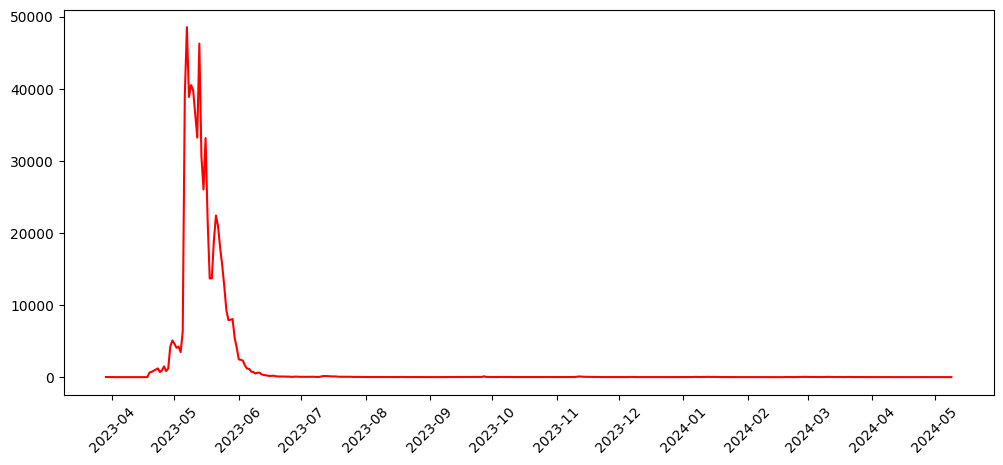

In [6]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

In [ ]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

SyntaxError: positional argument follows keyword argument (4129910871.py, line 5)

In [7]:
accounts_user['period_m'] = accounts_user['created_at'].dt.to_period('M')

In [12]:
month = accounts_user.groupby(['period_m'])[['id']].count().reset_index()

In [13]:
month['total'] = accounts_user['id'].count()

In [15]:
month['ratio'] = month['id'] / month['total']

In [ ]:
month # 2023년 5월에 93.85%가 가입하였습니다

,period_m,id,total,ratio
0,2023-03,33,677085,0.000049
1,2023-04,19060,677085,0.028150
2,2023-05,635505,677085,0.938590
3,2023-06,16737,677085,0.024719
4,2023-07,1849,677085,0.002731
5,2023-08,524,677085,0.000774
6,2023-09,605,677085,0.000894
7,2023-10,409,677085,0.000604
8,2023-11,731,677085,0.001080
9,2023-12,231,677085,0.000341


<Axes: xlabel='period_m'>

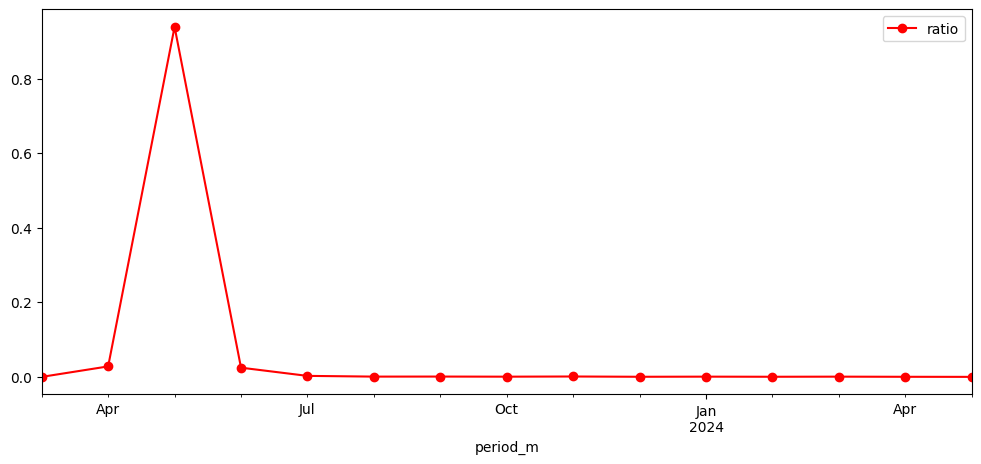

In [26]:
month.plot( x='period_m', y='ratio',figsize=(12, 5),marker = 'o', color='red')

In [80]:
user = accounts_user[['id','created_at']]

##### accounts_userquestionrecord

In [39]:
accounts_userquestionrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_userquestionrecord

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,161666166,C,2024-05-07 11:29:07,945560,2614,1001607,190864020,1,N,2024-05-07 11:29:07,0,0
1217554,161666461,C,2024-05-08 01:34:56,850774,1679,855525,200139931,0,N,2024-05-08 01:34:56,0,0
1217555,161666462,C,2024-05-08 01:35:02,855509,2605,855525,200139932,0,N,2024-05-08 01:35:02,0,0
1217556,161666463,C,2024-05-08 01:36:00,855526,3801,855525,200139933,0,N,2024-05-08 01:36:00,0,0


In [4]:
accounts_userquestionrecord.isnull().sum()

id                   0
status               0
created_at           0
chosen_user_id       0
question_id          0
user_id              0
question_piece_id    0
has_read             0
answer_status        0
answer_updated_at    0
report_count         0
opened_times         0
dtype: int64

In [ ]:
accounts_userquestionrecord.loc[(accounts_userquestionrecord['has_read']==1) & (accounts_userquestionrecord['answer_status']!='N')]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
345,778243,C,2023-04-28 13:14:34,849548,200,850006,1009125,1,P,2023-05-06 16:49:33,0,0
1848,802848,C,2023-04-28 16:05:09,849548,166,850610,1043525,1,P,2023-05-06 16:49:21,0,0
3097,815819,I,2023-04-28 23:31:19,849515,320,847375,1034711,1,P,2023-05-06 10:09:27,0,1
10109,945319,I,2023-04-29 13:22:05,849995,132,851717,1213085,1,P,2023-05-06 10:31:30,0,3
11512,989867,C,2023-04-29 15:20:38,849498,315,850180,1259999,1,A,2023-05-12 15:33:47,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1182397,150784898,C,2023-06-07 15:41:57,887991,2356,883374,191553936,1,A,2023-06-07 15:42:58,0,0
1182400,150785481,C,2023-06-07 15:42:37,887991,3822,883374,191553939,1,A,2023-06-07 15:43:09,0,0
1182563,150825226,C,2023-06-07 16:41:50,869580,2285,877117,192477279,1,A,2023-06-07 16:43:00,0,0
1182570,150825637,I,2023-06-07 16:42:40,887714,2357,869580,190234929,1,A,2023-06-07 17:40:52,0,1


In [40]:
accounts_userquestionrecord = accounts_userquestionrecord.sort_values(by='answer_updated_at')

In [41]:
accounts_userquestionrecord = accounts_userquestionrecord.drop_duplicates(subset=['user_id'], keep='last')[['user_id','answer_updated_at']].rename(columns={'answer_updated_at': 'created_at'})

##### accounts_userwithdraw

In [5]:
accounts_userwithdraw = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet', engine='pyarrow')

In [6]:
accounts_userwithdraw

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19
...,...,...,...
70759,70889,기타 이유,2024-05-08 14:24:16
70760,70890,함께 할 친구가 없어서,2024-05-08 15:20:06
70761,70891,재밌는 질문이 없어서,2024-05-08 15:46:36
70762,70892,기타 이유,2024-05-09 08:29:09


In [7]:
accounts_userwithdraw.isnull().sum()

id            0
reason        0
created_at    0
dtype: int64

##### event_receipts

In [42]:
event_receipts = pd.read_parquet('gs://sprintda05_final_project/votes/event_receipts.parquet', engine='pyarrow')

In [ ]:
event_receipts.sort_values(by='created_at', ascending=False)

,id,created_at,event_id,user_id,plus_point
308,321,2023-11-21 12:03:02,3,1568685,500
307,320,2023-11-17 06:17:59,3,1296978,500
306,319,2023-11-17 06:17:25,3,1188104,500
305,318,2023-11-15 05:09:02,3,932419,500
304,317,2023-11-14 11:17:29,3,918053,500
...,...,...,...,...,...
4,6,2023-06-22 13:40:38,1,1168260,500
3,5,2023-06-22 13:03:06,1,974697,500
2,4,2023-06-22 10:32:15,1,904872,500
1,3,2023-06-22 09:38:53,1,928351,500


In [10]:
event_receipts.isnull().sum()

id            0
created_at    0
event_id      0
user_id       0
plus_point    0
dtype: int64

In [19]:
event_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [30]:
event_receipts['plus_point'].unique()

array([ 500, 1000])

In [ ]:
event_plus_point = event_receipts.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

,user_id,plus_point
0,837836,1000
1,1541150,1000
2,1115176,1000
3,1107696,1000
4,1512731,1000
...,...,...
303,1062030,500
304,1061829,500
305,1056997,500
306,1056664,500


In [44]:
event_receipts = event_receipts.sort_values(by='created_at')

In [45]:
event_receipts = event_receipts.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### events

In [11]:
events = pd.read_parquet('gs://sprintda05_final_project/votes/events.parquet', engine='pyarrow')

In [12]:
events

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


In [13]:
events.isnull().sum()

id            0
title         0
plus_point    0
event_type    0
is_expired    0
created_at    0
dtype: int64

##### polls_question

In [46]:
polls_question = pd.read_parquet('gs://sprintda05_final_project/votes/polls_question.parquet', engine='pyarrow')

In [52]:
polls_question

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55
...,...,...,...
5020,5129,나에게 가장 중요한 사람은?,2023-06-06 06:15:52
5021,5130,오목을 제일 잘 할 것 같은 사람은?,2023-06-06 06:15:52
5022,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,2023-06-06 06:15:52
5023,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,2023-06-06 06:15:52


In [16]:
polls_question.isnull().sum()

id               0
question_text    0
created_at       0
dtype: int64

In [30]:
hour = polls_question['created_at'].dt.hour

In [35]:
polls_question.loc[polls_question['created_at'].dt.hour == 3]

,id,question_text,created_at
462,561,얘랑 친해지면 세상 모두랑 친해질 수 있을 것 같았던 사람은?,2023-05-04 03:36:37


In [38]:
hour.value_counts()

created_at
6     1966
8     1523
14     732
13     250
5      235
15     164
11     154
3        1
Name: count, dtype: int64

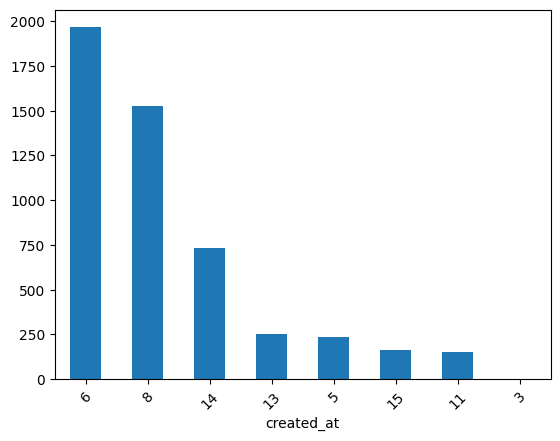

In [ ]:
hour.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [60]:
polls_question.loc[polls_question['id'].isin([170,169,186,211,290])]

,id,question_text,created_at
70,169,축제에서 공연을 제일 잘 할거 같은 사람은?,2023-03-31 15:23:29
71,170,처음 보는 사람과 가장 빨리 친해질 것 같은 사람은?,2023-03-31 15:23:30
87,186,vote,2023-04-01 11:09:15
112,211,앞으로의 인생을 가장 재미있게 살것 같은 사람은?,2023-04-01 11:09:20
191,290,모든 사람과 잘 지낼 것 같은 사람은?,2023-04-01 11:09:35


In [30]:
polls_question.loc[polls_question['id']==111]

,id,question_text,created_at
12,111,마스크가 잘 어울리는 사람은?,2023-03-31 15:22:59


In [26]:
df = pd.merge(polls_question,report,how='left',on='id')

In [36]:
df1 = df[df['question_text'].str.contains('vote',case=False)]

In [74]:
df2 = pd.merge(df1,piece_count,how='left',on='id') 
df2

,id,question_text,created_at,count,count1
0,186,vote,2023-04-01 11:09:15,45.0,1991.0
1,483,vote,2023-05-02 05:33:11,73.0,1615.0
2,639,vote,2023-05-11 15:52:44,16.0,580.0
3,696,vote,2023-05-15 13:58:24,34.0,411.0
4,712,vote,2023-05-15 13:58:30,15.0,381.0
5,725,vote,2023-05-15 13:58:35,7.0,392.0
6,736,vote,2023-05-15 13:58:40,32.0,358.0
7,807,vote,2023-05-15 13:59:11,34.0,357.0
8,881,vote,2023-05-15 13:59:44,39.0,365.0
9,940,vote,2023-05-15 14:00:10,20.0,333.0


In [81]:
vote_text = df2['id'].to_list()

In [28]:
polls_question[polls_question['question_text'].str.contains('vote', case=False)].head(5)

,id,question_text,created_at
87,186,vote,2023-04-01 11:09:15
384,483,vote,2023-05-02 05:33:11
540,639,vote,2023-05-11 15:52:44
587,696,vote,2023-05-15 13:58:24
603,712,vote,2023-05-15 13:58:30


##### polls_questionpiece

In [47]:
polls_questionpiece = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionpiece.parquet', engine='pyarrow')

In [15]:
polls_questionpiece

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0
...,...,...,...,...,...
1265471,208385226,0,2024-05-07 11:32:30,960,0
1265472,208385227,0,2024-05-07 11:32:30,1402,0
1265473,208385228,0,2024-05-07 11:32:30,1676,0
1265474,208385229,0,2024-05-07 11:32:30,3115,0


In [13]:
piece_count = polls_questionpiece.groupby(['question_id'])[['id']].count().sort_values(by='id',ascending=False).reset_index().rename(columns={'id' : 'count1','question_id': 'id'})

In [ ]:
piece_count

,id,count1
0,170,2030
1,290,2021
2,169,2017
3,211,2009
4,186,1991
...,...,...
4939,4926,1
4940,4556,1
4941,4551,1
4942,4931,1


In [51]:
piece_count.describe()

,id,count1
count,4944.000000,4944.000000
mean,2587.901699,255.961974
std,1441.905349,478.950128
min,99.000000,1.000000
25%,1344.750000,14.000000
50%,2580.500000,33.000000
75%,3816.250000,355.000000
max,5133.000000,2030.000000


In [87]:
vote_questionpiece = polls_questionpiece.loc[polls_questionpiece['question_id'].isin(vote_text),'id'].to_list()

In [12]:
questionpiece_voted = polls_questionpiece.groupby(['question_id'])[['is_voted']].sum().sort_values(by='is_voted',ascending=False).reset_index().rename(columns={'is_voted': 'count2','question_id': 'id'})

In [17]:
piece_voted_count = pd.merge(piece_count,questionpiece_voted,how='left',on='id').sort_values(by='count1',ascending=False)

In [19]:
piece_voted_count['ratio'] = piece_voted_count['count2'] / piece_voted_count['count1']

In [25]:
piece_voted_count.describe()

,id,count1,count2,ratio
count,4944.000000,4944.000000,4944.000000,4944.000000
mean,2587.901699,255.961974,246.498180,0.801884
std,1441.905349,478.950128,470.798358,0.208031
min,99.000000,1.000000,0.000000,0.000000
25%,1344.750000,14.000000,10.000000,0.729730
50%,2580.500000,33.000000,27.000000,0.837838
75%,3816.250000,355.000000,340.000000,0.963418
max,5133.000000,2030.000000,1998.000000,1.000000


##### polls_questionreport

In [48]:
polls_questionreport = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionreport.parquet', engine='pyarrow')

In [ ]:
polls_questionreport

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922
...,...,...,...,...,...
51419,55763,그냥 싫어,2024-04-19 12:49:57,350,1542237
51420,55764,그냥 싫어,2024-04-19 12:50:02,3541,1542237
51421,55765,그냥 싫어,2024-04-28 06:35:38,392,984791
51422,55766,그냥 싫어,2024-04-30 04:48:25,4979,1583634


In [65]:
polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id': 'count'}).sort_values(by='count', ascending=False)

,question_id,count
12,111,988
311,410,803
299,398,660
325,424,533
206,305,493
...,...,...
2439,2980,1
1801,2019,1
2441,2983,1
2443,2986,1


In [ ]:
polls_questionreport.loc[polls_questionreport['question_id']==111]

In [60]:
report = polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id' : 'count', 'question_id': 'id'}).sort_values(by='count',ascending=False)

In [64]:
report.head(5) 

,id,count
12,111,988
311,410,803
299,398,660
325,424,533
206,305,493


In [ ]:
report.describe()

,id,count
count,3135.000000,3135.000000
mean,1921.597448,16.403190
std,1231.248878,38.455215
min,99.000000,1.000000
25%,892.500000,1.000000
50%,1682.000000,4.000000
75%,2849.000000,19.000000
max,5110.000000,988.000000


In [49]:
polls_questionreport = polls_questionreport.sort_values(by='created_at')

In [50]:
polls_questionreport = polls_questionreport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_questionset

In [51]:
polls_questionset = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionset.parquet', engine='pyarrow')

In [68]:
polls_questionset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [21]:
polls_questionset

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...,...
158379,20838253,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933
158380,20838344,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072
158381,20838419,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878
158382,20838445,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607


In [55]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [56]:
explode_questionset = polls_questionset.explode('question_piece_id_list')

In [ ]:
polls_questionset  = polls_questionset.explode('question_piece_id_list')

In [58]:
explode_questionset

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,998458,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998459,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998460,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998461,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998462,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
...,...,...,...,...,...,...
158383,20838446,208385226,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385227,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385228,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385229,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560


In [88]:
# text가 vote인 질문을 사용한 유저
explode_questionset.loc[explode_questionset['question_piece_id_list'].isin(vote_questionpiece)]

,id,question_piece_id_list,opening_time,status,created_at,user_id
11,99877,999061,2023-04-28 12:30:30,F,2023-04-28 12:30:30,849452
47,100144,1001728,2023-04-28 13:27:10,F,2023-04-28 12:37:10,849446
82,100659,1006883,2023-04-28 13:49:51,F,2023-04-28 12:59:52,849464
102,100956,1009852,2023-04-28 14:05:03,F,2023-04-28 13:15:03,850006
179,101876,1019049,2023-04-28 13:57:38,F,2023-04-28 13:57:38,849535
...,...,...,...,...,...,...
158367,20834940,208350163,2024-03-17 09:05:21,O,2024-03-17 08:25:21,1165963
158368,20835030,208351069,2024-03-18 15:35:54,C,2024-03-18 14:55:54,1260879
158375,20836712,208367887,2024-04-18 03:03:30,O,2024-04-18 02:23:30,1087583
158379,20838253,208383297,2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933


In [ ]:
questionset = polls_questionset.groupby(['user_id'])[['id']].count().sort_values(by='id', ascending=False).reset_index()
questionset

,user_id,id
0,952220,370
1,849103,286
2,1184703,215
3,1162477,203
4,1213990,202
...,...,...
4967,1500850,1
4968,899404,1
4969,872546,1
4970,872930,1


In [24]:
conversion = pd.merge(payment,questionset,how='left',on='user_id')
conversion

,user_id,id_x,id_y
0,1527451,60,NaN
1,1246471,51,NaN
2,1141603,35,NaN
3,1204373,34,NaN
4,1142775,30,NaN
...,...,...,...
59187,1196164,1,NaN
59188,1196170,1,NaN
59189,1196185,1,NaN
59190,1196197,1,NaN


In [10]:
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

In [14]:
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

In [16]:
print(len(payment_in_users),len(questionset_in_users),len(both_users))

59192 4972 410


In [17]:
data = {'결제자' : len(payment_in_users), 
       '질문세트 작성자' : len(questionset_in_users), 
       '둘 다 작성한 유저' : len(both_users)}

In [9]:
print("🔍 사용자 ID 기반 정확한 전환율 분석")
print("=" * 50)

print("📊 **Step 1: 각 데이터셋의 사용자 ID 확인**")

# 각 데이터셋의 사용자 ID 타입과 분포 확인
print(f"• df_user['id'] 타입: {accounts_user['id'].dtype}")
print(f"• df_payment['user_id'] 타입: {accounts_paymenthistory['user_id'].dtype}")  
print(f"• df_questionset['user_id'] 타입: {polls_questionset['user_id'].dtype}")

print(f"\n• df_user ID 범위: {accounts_user['id'].min()} ~ {accounts_user['id'].max()}")
print(f"• df_payment user_id 범위: {accounts_paymenthistory['user_id'].min()} ~ {accounts_paymenthistory['user_id'].max()}")
print(f"• df_questionset user_id 범위: {polls_questionset['user_id'].min()} ~ {polls_questionset['user_id'].max()}")

# 실제 사용자 집합 정의
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

print(f"\n📋 **Step 2: 사용자 집합 재확인**")
print(f"• 전체 등록 사용자: {len(all_users):,}명")
print(f"• 결제한 사용자: {len(payment_users):,}명")
print(f"• 질문세트 사용한 사용자: {len(questionset_users):,}명")

# 교집합 확인
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

print(f"\n🔍 **Step 3: 교집합 분석**")
print(f"• 전체 사용자 중 결제한 사용자: {len(payment_in_users):,}명")
print(f"• 전체 사용자 중 질문세트 사용한 사용자: {len(questionset_in_users):,}명")
print(f"• 결제도 하고 질문세트도 사용한 사용자: {len(both_users):,}명")

# 사용자가 실제로 존재하는지 확인
print(f"\n🔎 **Step 4: 사용자 존재 여부 확인**")
payment_not_in_users = payment_users - all_users
questionset_not_in_users = questionset_users - all_users

print(f"• 결제했지만 사용자 테이블에 없는 ID: {len(payment_not_in_users):,}개")
print(f"• 질문세트 사용했지만 사용자 테이블에 없는 ID: {len(questionset_not_in_users):,}개")

if len(payment_not_in_users) > 0:
    print(f"  예시: {list(payment_not_in_users)[:5]}")
if len(questionset_not_in_users) > 0:
    print(f"  예시: {list(questionset_not_in_users)[:5]}")

# 올바른 전환율 계산
print(f"\n✅ **Step 5: 올바른 전환율 계산**")

# 1. 전체 사용자 중 결제 전환율
basic_conversion = len(payment_in_users) / len(all_users) * 100
print(f"• 전체 사용자 → 결제 전환율: {basic_conversion:.2f}% ({len(payment_in_users):,}/{len(all_users):,})")

# 2. 질문세트 사용자 중 결제 전환율  
if len(questionset_in_users) > 0:
    questionset_to_payment = len(both_users) / len(questionset_in_users) * 100
    print(f"• 질문세트 사용자 → 결제 전환율: {questionset_to_payment:.2f}% ({len(both_users):,}/{len(questionset_in_users):,})")

# 3. 결제 사용자 중 질문세트 사용률
if len(payment_in_users) > 0:
    payment_to_questionset = len(both_users) / len(payment_in_users) * 100
    print(f"• 결제 사용자 중 질문세트 사용률: {payment_to_questionset:.2f}% ({len(both_users):,}/{len(payment_in_users):,})")

# 사용자 행동 패턴 분석
print(f"\n🎯 **사용자 행동 패턴**")
payment_only = payment_users - questionset_users
questionset_only = questionset_users - payment_users

print(f"• 결제만 하는 사용자: {len(payment_only):,}명 ({len(payment_only)/len(payment_users)*100:.1f}%)")
print(f"• 질문세트만 사용하는 사용자: {len(questionset_only):,}명 ({len(questionset_only)/len(questionset_users)*100:.1f}%)")
print(f"• 둘 다 하는 사용자: {len(both_users):,}명")

print(f"\n📊 **결론**:")
if len(payment_only) > len(both_users) * 10:
    print(f"• 질문세트는 최근 추가된 기능으로 보임")
    print(f"• 기존 결제 사용자들은 다른 기능을 주로 사용")
    print(f"• 질문세트 → 결제 전환율: {questionset_to_payment:.1f}%는 의미있는 지표")
else:
    print(f"• 질문세트와 결제 기능이 밀접하게 연관됨")

🔍 사용자 ID 기반 정확한 전환율 분석
📊 **Step 1: 각 데이터셋의 사용자 ID 확인**
• df_user['id'] 타입: int64
• df_payment['user_id'] 타입: int64
• df_questionset['user_id'] 타입: int64

• df_user ID 범위: 831956 ~ 1583733
• df_payment user_id 범위: 833041 ~ 1583632
• df_questionset user_id 범위: 838023 ~ 1583358

📋 **Step 2: 사용자 집합 재확인**
• 전체 등록 사용자: 677,085명
• 결제한 사용자: 59,192명
• 질문세트 사용한 사용자: 4,972명

🔍 **Step 3: 교집합 분석**
• 전체 사용자 중 결제한 사용자: 59,192명
• 전체 사용자 중 질문세트 사용한 사용자: 4,972명
• 결제도 하고 질문세트도 사용한 사용자: 410명

🔎 **Step 4: 사용자 존재 여부 확인**
• 결제했지만 사용자 테이블에 없는 ID: 0개
• 질문세트 사용했지만 사용자 테이블에 없는 ID: 0개

✅ **Step 5: 올바른 전환율 계산**
• 전체 사용자 → 결제 전환율: 8.74% (59,192/677,085)
• 질문세트 사용자 → 결제 전환율: 8.25% (410/4,972)
• 결제 사용자 중 질문세트 사용률: 0.69% (410/59,192)

🎯 **사용자 행동 패턴**
• 결제만 하는 사용자: 58,782명 (99.3%)
• 질문세트만 사용하는 사용자: 4,562명 (91.8%)
• 둘 다 하는 사용자: 410명

📊 **결론**:
• 질문세트는 최근 추가된 기능으로 보임
• 기존 결제 사용자들은 다른 기능을 주로 사용
• 질문세트 → 결제 전환율: 8.2%는 의미있는 지표


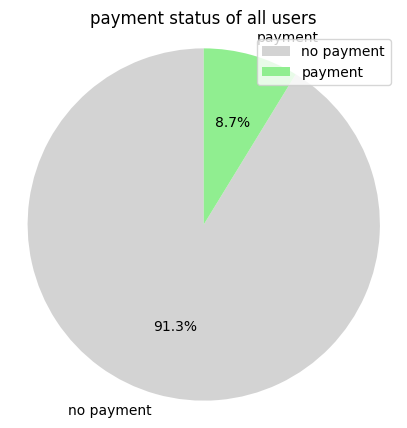

In [30]:
import matplotlib.pyplot as plt

# 전체 사용자 대비 결제 여부
labels = ['no payment', 'payment']
sizes = [len(all_users) - len(payment_in_users), len(payment_in_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgray', 'lightgreen'])
plt.axis('equal')
plt.title('payment status of all users')
plt.legend(loc= 'upper right')
plt.show()

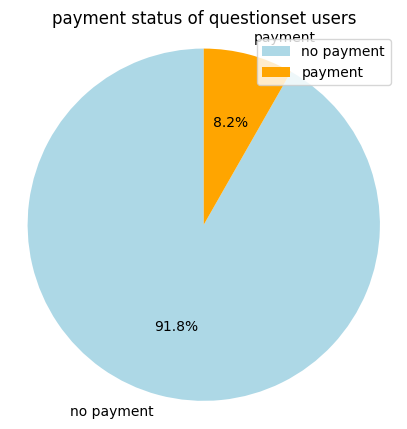

In [31]:
# 질문세트 사용자 대비 결제 여부
labels = ['no payment', 'payment']
sizes = [len(questionset_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange'])
plt.axis('equal')
plt.title('payment status of questionset users')
plt.legend(loc= 'upper right')
plt.show()


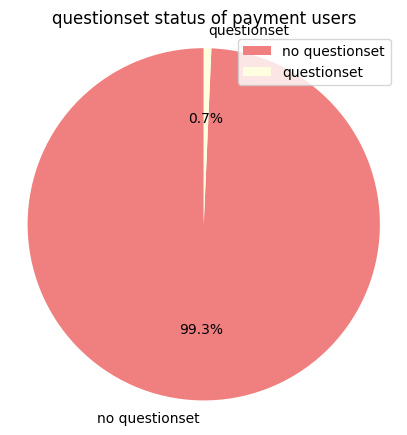

In [32]:
# 결제 사용자 중 질문세트 사용 여부
labels = ['no questionset', 'questionset']
sizes = [len(payment_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightyellow'])
plt.axis('equal')
plt.title('questionset status of payment users')
plt.legend(loc= 'upper right')
plt.show()


In [ ]:
polls_questionset= polls_questionset.sort_values(by='created_at')

In [ ]:
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_usercandidate

In [63]:
polls_usercandidate = pd.read_parquet('gs://sprintda05_final_project/votes/polls_usercandidate.parquet', engine='pyarrow')

In [3]:
polls_usercandidate

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
...,...,...,...,...
4769604,646672580,2024-05-08 01:36:00,200139933,857296
4769605,646672581,2024-05-08 01:36:18,200139934,850774
4769606,646672582,2024-05-08 01:36:18,200139934,856446
4769607,646672583,2024-05-08 01:36:18,200139934,857101


In [102]:
polls_usercandidate = polls_usercandidate.sort_values(by='created_at')

In [103]:
polls_usercandidate = polls_usercandidate.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

#### 유행 현상 해부

In [2]:
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')

In [3]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
attend = accounts_attendance.explode('attendance_date_list')
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

In [4]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

In [5]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
polls_questionset  = polls_questionset.explode('question_piece_id_list')
polls_questionset= polls_questionset.sort_values(by='created_at')
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

In [9]:
user = accounts_user[['id','created_at']]

In [10]:
data = [accounts_blockrecord,accounts_failpaymenthistory,accounts_paymenthistory,accounts_pointhistory,accounts_timelinereport,accounts_userquestionrecord,event_receipts,polls_questionreport]

In [11]:
data1 = []
for i in data:
    i = i.sort_values(by='created_at')
    i = i.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]
    data1.append(i)

In [26]:
data1.append(accounts_attendance)
data1.append(accounts_friendrequest)
data1.append(polls_questionset)

In [27]:
active = pd.concat(data1, ignore_index=True)

In [28]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087088 entries, 0 to 1087087
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1087088 non-null  int64 
 1   created_at  1087088 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.6+ MB


In [29]:
active['created_at'] = pd.to_datetime(active['created_at'])

In [30]:
active = active.sort_values(by='created_at', ascending=True)

In [31]:
active = active.drop_duplicates(subset=['user_id'], keep='last')

In [32]:
active.rename(columns={'created_at': 'last_active_at', 'user_id' : 'id'}, inplace=True)

In [33]:
active

,id,last_active_at
433044,837521,2023-04-17 18:29:11
433045,837541,2023-04-19 06:07:20
433046,837542,2023-04-19 06:07:26
433048,837570,2023-04-19 06:10:48
433049,837607,2023-04-19 06:17:23
...,...,...
1082111,1583732,2024-05-09 07:23:12
1082112,1583731,2024-05-09 07:24:50
1082113,1583673,2024-05-09 07:31:41
1082114,1575671,2024-05-09 08:20:44


In [35]:
active_ra = pd.merge(user,active,how='left',on='id')

In [36]:
active_ra.isnull().sum()

id                    0
created_at            0
last_active_at    23820
dtype: int64

In [23]:
active_ra

,id,created_at,last_active_at
0,831956,2023-03-29 03:44:14.047130,NaT
1,831962,2023-03-29 05:18:56.162368,NaT
2,832151,2023-03-29 12:56:34.989468,NaT
3,832340,2023-03-29 12:56:35.020790,2023-04-25 20:17:00
4,832520,2023-03-29 12:56:35.049311,NaT
...,...,...,...
677080,1583729,2024-05-08 21:54:33.621408,NaT
677081,1583730,2024-05-09 07:08:11.001817,NaT
677082,1583731,2024-05-09 07:22:19.186439,NaT
677083,1583732,2024-05-09 07:22:38.387553,NaT


In [136]:
active_ra['created_at'] = active_ra['created_at'].dt.to_period('d').astype(str)
active_ra['last_active_at'] = active_ra['last_active_at'].dt.to_period('d').astype(str)

In [137]:
active_ra

,id,created_at,last_active_at
0,831956,2023-03-29,NaT
1,831962,2023-03-29,NaT
2,832151,2023-03-29,NaT
3,832340,2023-03-29,2023-04-25
4,832520,2023-03-29,NaT
...,...,...,...
677080,1583729,2024-05-08,NaT
677081,1583730,2024-05-09,NaT
677082,1583731,2024-05-09,NaT
677083,1583732,2024-05-09,NaT


In [138]:
active_ra[active_ra['last_active_at']=='NaT']

,id,created_at,last_active_at
0,831956,2023-03-29,NaT
1,831962,2023-03-29,NaT
2,832151,2023-03-29,NaT
4,832520,2023-03-29,NaT
5,832614,2023-03-29,NaT
...,...,...,...
677080,1583729,2024-05-08,NaT
677081,1583730,2024-05-09,NaT
677082,1583731,2024-05-09,NaT
677083,1583732,2024-05-09,NaT


#### 서비스 확산 패턴 확인

In [2]:
accounts_group = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_group.parquet", engine='pyarrow')
accounts_nearbyschool = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet", engine='pyarrow')
accounts_school = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_school.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')

In [10]:
accounts_school

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [45]:
accounts_group

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [3]:
accounts_group = accounts_group.rename(columns={'id': 'group_id'})

In [4]:
accounts_user_gr = accounts_user[['id','group_id','created_at']]

In [5]:
accounts_user_gr = accounts_user_gr[accounts_user_gr['group_id'].isnull() ==False].reset_index(drop=True)

In [6]:
merge_user_gr = pd.merge(accounts_user_gr,accounts_group, how='left', on='group_id').drop(columns=['grade','class_num','group_id'])

In [7]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [8]:
merge_user_gr.sort_values(by='created_at', ascending=True)

,id,created_at,school_id
0,831962,2023-03-29 05:18:56.162368,1
1,832151,2023-03-29 12:56:34.989468,1
2,832340,2023-03-29 12:56:35.020790,1
3,832520,2023-03-29 12:56:35.049311,1
4,832614,2023-03-29 12:56:35.064406,1
...,...,...,...
677077,1583729,2024-05-08 21:54:33.621408,2389
677078,1583730,2024-05-09 07:08:11.001817,2969
677079,1583731,2024-05-09 07:22:19.186439,2579
677080,1583732,2024-05-09 07:22:38.387553,2579


In [19]:
df = pd.merge(accounts_nearbyschool,merge_user_gr,how='left',on='school_id')
df

,distance,nearby_school_id,school_id,id,created_at
0,0.004564,6,7,844076.0,2023-04-23 16:38:29.093925
1,0.004564,6,7,860672.0,2023-04-30 14:25:16.977793
2,0.004564,6,7,925325.0,2023-05-06 15:21:56.694859
3,0.004564,6,7,949808.0,2023-05-07 07:26:25.056638
4,0.004564,6,7,982351.0,2023-05-07 17:25:49.541950
...,...,...,...,...,...
6773505,0.000000,5961,5961,1571373.0,2023-06-07 04:03:06.713254
6773506,0.000000,5961,5961,1572245.0,2023-06-08 06:30:48.316400
6773507,0.000000,5961,5961,1572259.0,2023-06-08 06:52:54.737776
6773508,0.000000,5961,5961,1573564.0,2023-06-10 05:03:19.155910


=== 데이터 전처리 중... ===
=== 데이터 기본 정보 ===
총 레코드 수: 6,773,510
고유 학생 수: 676,950
고유 학교 수: 5,950
데이터 기간: 2023-03-31 09:05:51.903699 ~ 2024-05-09 08:31:17.710824

=== 월별 분석 실행 중... ===
=== 월별 누적 증가 분석 ===
      month  cumulative_students  cumulative_schools  monthly_new_students  \
0   2023-03                   22                   5                    22   
1   2023-04                19052                1310                 19030   
2   2023-05               654530                5496                635478   
3   2023-06               671264                5528                 16734   
4   2023-07               673097                5536                  1833   
5   2023-08               673616                5539                   519   
6   2023-09               674180                5544                   564   
7   2023-10               674587                5544                   407   
8   2023-11               675318                5545                   731   
9   2023-12            

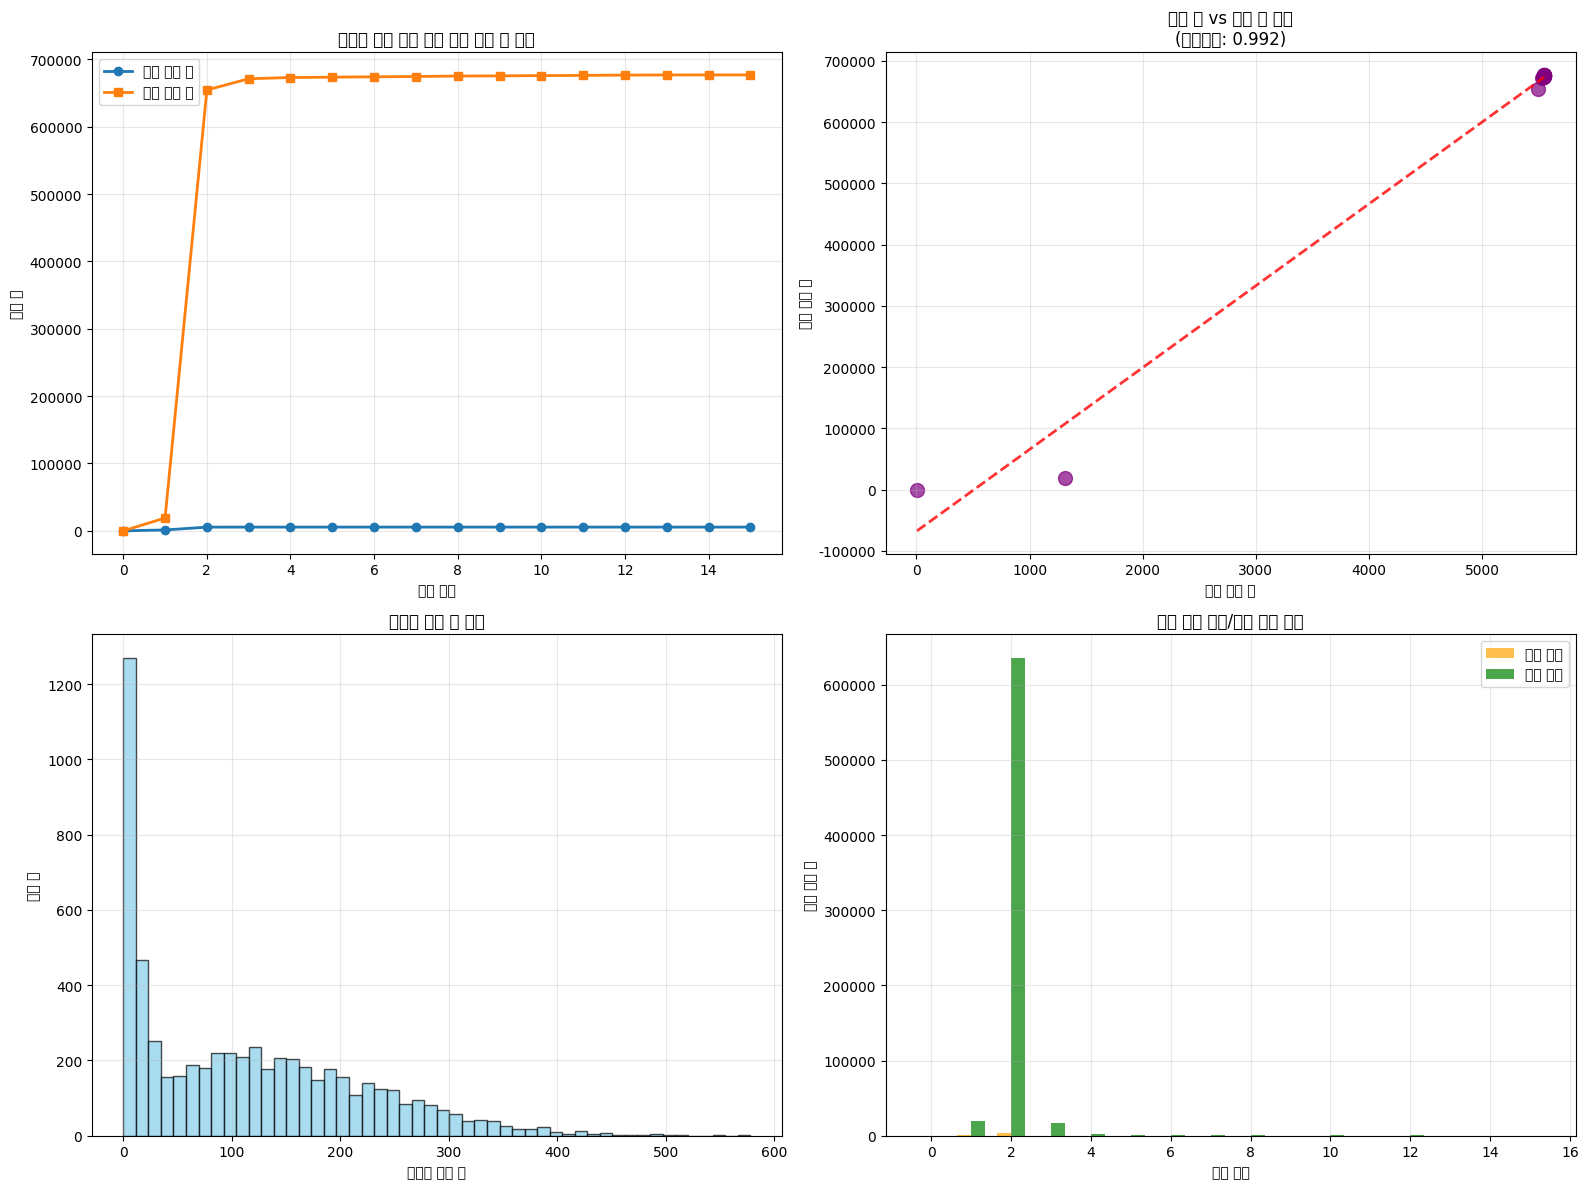

=== 추가 분석 결과 ===
가장 많은 학생이 누적된 시점: 2024-05
해당 시점 학교 수: 5,549
해당 시점 학생 수: 676,950

기간 동안 학교 수 증가율: 110880.0%
기간 동안 학생 수 증가율: 3076945.5%

=== 결론 ===
1. 데이터 무결성이 검증되었습니다 (월별 신규 합계 = 전체 수)
2. 성능이 크게 개선되었습니다 (NetworkX 그래프 생성 생략)
3. 상관관계 분석으로 학교 수와 학생 수의 관계를 정확히 파악할 수 있습니다.

실제 데이터로 교체하여 분석하세요!


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict



# 성능 최적화: 데이터 전처리를 한 번에 수행
print("=== 데이터 전처리 중... ===")
df['created_at'] = pd.to_datetime(df['created_at'])
df['month'] = df['created_at'].dt.to_period('M')
df = df.sort_values('created_at')

print("=== 데이터 기본 정보 ===")
print(f"총 레코드 수: {len(df):,}")
print(f"고유 학생 수: {df['id'].nunique():,}")
print(f"고유 학교 수: {df['school_id'].nunique():,}")
print(f"데이터 기간: {df['created_at'].min()} ~ {df['created_at'].max()}")
print()

# 성능 최적화된 시간대별 분석
def analyze_by_time_period_optimized(df):
    """성능 최적화된 시간대별 분석 - 논리적 오류 수정"""
    
    # 각 학생과 학교의 첫 등장 월 찾기 (성능 최적화)
    student_first_month = df.groupby('id')['month'].min()
    school_first_month = df.groupby('school_id')['month'].min()
    
    # 월별 정보를 딕셔너리로 미리 계산
    months = sorted(df['month'].unique())
    monthly_stats = []
    
    seen_students = set()
    seen_schools = set()
    
    for month in months:
        # 해당 월에 처음 등장한 학생과 학교 찾기
        new_students_this_month = set(student_first_month[student_first_month == month].index)
        new_schools_this_month = set(school_first_month[school_first_month == month].index)
        
        # 누적 집합에 추가
        seen_students.update(new_students_this_month)
        seen_schools.update(new_schools_this_month)
        
        stats = {
            'month': str(month),
            'cumulative_students': len(seen_students),
            'cumulative_schools': len(seen_schools),
            'monthly_new_students': len(new_students_this_month),
            'monthly_new_schools': len(new_schools_this_month)
        }
        monthly_stats.append(stats)
    
    return pd.DataFrame(monthly_stats)

# 성능 최적화된 네트워크 분석
def analyze_network_properties_optimized(df):
    """성능 최적화된 네트워크 분석"""
    
    # 직접 degree 계산 (NetworkX 생성 없이)
    school_student_count = df.groupby('school_id')['id'].nunique().to_dict()
    student_school_count = df.groupby('id')['school_id'].nunique().to_dict()
    
    total_students = df['id'].nunique()
    total_schools = df['school_id'].nunique()
    total_connections = len(df)
    
    print("=== 네트워크 분석 결과 ===")
    print(f"고유 학생 수: {total_students:,}")
    print(f"고유 학교 수: {total_schools:,}")
    print(f"총 연결 수: {total_connections:,}")
    print()
    
    print("=== 학교별 학생 수 분포 ===")
    school_counts = list(school_student_count.values())
    print(f"평균 학교당 학생 수: {np.mean(school_counts):.2f}")
    print(f"학교당 학생 수 표준편차: {np.std(school_counts):.2f}")
    print(f"최대 학생 수를 가진 학교: {max(school_counts):,}명")
    print(f"최소 학생 수를 가진 학교: {min(school_counts):,}명")
    print()
    
    print("=== 학생별 학교 수 분포 ===")
    student_counts = list(student_school_count.values())
    print(f"평균 학생당 학교 수: {np.mean(student_counts):.2f}")
    print(f"학생당 학교 수 표준편차: {np.std(student_counts):.2f}")
    print()
    
    return school_student_count, student_school_count

# 최적화된 분석 실행
print("=== 월별 분석 실행 중... ===")
monthly_analysis = analyze_by_time_period_optimized(df)

print("=== 월별 누적 증가 분석 ===")
print(monthly_analysis)
print()

# 검증: 월별 신규 합계가 전체와 일치하는지 확인
total_new_students = monthly_analysis['monthly_new_students'].sum()
total_new_schools = monthly_analysis['monthly_new_schools'].sum()
actual_total_students = df['id'].nunique()
actual_total_schools = df['school_id'].nunique()

print("=== 데이터 무결성 검증 ===")
print(f"월별 신규 학생 합계: {total_new_students:,}")
print(f"실제 총 학생 수: {actual_total_students:,}")
print(f"학생 수 일치: {'✓' if total_new_students == actual_total_students else '✗'}")
print()
print(f"월별 신규 학교 합계: {total_new_schools:,}")
print(f"실제 총 학교 수: {actual_total_schools:,}")
print(f"학교 수 일치: {'✓' if total_new_schools == actual_total_schools else '✗'}")
print()

# 네트워크 분석 실행
print("=== 네트워크 분석 실행 중... ===")
school_degrees, student_degrees = analyze_network_properties_optimized(df)

# 상관관계 분석
print("=== 학교 수와 학생 수 상관관계 분석 ===")
correlation = monthly_analysis['cumulative_schools'].corr(monthly_analysis['cumulative_students'])
print(f"학교 수와 학생 수의 상관계수: {correlation:.4f}")

if correlation > 0.8:
    print("→ 강한 양의 상관관계: 학교 수가 증가하면 학생 수도 크게 증가")
elif correlation > 0.5:
    print("→ 중간 양의 상관관계: 학교 수가 증가하면 학생 수도 어느 정도 증가")
elif correlation > 0.2:
    print("→ 약한 양의 상관관계: 학교 수와 학생 수 증가가 약간 관련")
else:
    print("→ 상관관계 낮음: 학교 수와 학생 수 증가가 직접적으로 연관되지 않음")
print()

# 성능 최적화된 시각화
print("=== 시각화 생성 중... ===")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 누적 학교 수와 학생 수 변화
ax1 = axes[0, 0]
monthly_analysis['month_num'] = range(len(monthly_analysis))
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_schools'], 
         marker='o', label='누적 학교 수', linewidth=2, markersize=6)
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_students'], 
         marker='s', label='누적 학생 수', linewidth=2, markersize=6)
ax1.set_xlabel('시간 순서')
ax1.set_ylabel('누적 수')
ax1.set_title('시간에 따른 누적 학교 수와 학생 수 변화')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 학교 수 vs 학생 수 산점도
ax2 = axes[0, 1]
ax2.scatter(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 
           s=100, alpha=0.7, color='purple')
ax2.set_xlabel('누적 학교 수')
ax2.set_ylabel('누적 학생 수')
ax2.set_title(f'학교 수 vs 학생 수 관계\n(상관계수: {correlation:.3f})')
ax2.grid(True, alpha=0.3)

# 추세선 추가
if len(monthly_analysis) >= 2:
    z = np.polyfit(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 1)
    p = np.poly1d(z)
    ax2.plot(monthly_analysis['cumulative_schools'], p(monthly_analysis['cumulative_schools']), 
             "r--", alpha=0.8, linewidth=2)

# 3. 학교별 학생 수 분포
ax3 = axes[1, 0]
school_counts = list(school_degrees.values())
bins = min(50, max(1, len(set(school_counts))))  # 최대 50개 bin
ax3.hist(school_counts, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('학교당 학생 수')
ax3.set_ylabel('학교 수')
ax3.set_title('학교별 학생 수 분포')
ax3.grid(True, alpha=0.3)

# 4. 월별 신규 등록 현황
ax4 = axes[1, 1]
width = 0.35
x = monthly_analysis['month_num']
ax4.bar([i - width/2 for i in x], monthly_analysis['monthly_new_schools'], 
        width, label='신규 학교', alpha=0.7, color='orange')
ax4.bar([i + width/2 for i in x], monthly_analysis['monthly_new_students'], 
        width, label='신규 학생', alpha=0.7, color='green')
ax4.set_xlabel('시간 순서')
ax4.set_ylabel('신규 등록 수')
ax4.set_title('월별 신규 학교/학생 등록 현황')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 추가 인사이트
print("=== 추가 분석 결과 ===")
max_month_idx = monthly_analysis['cumulative_students'].idxmax()
peak_month = monthly_analysis.iloc[max_month_idx]
print(f"가장 많은 학생이 누적된 시점: {peak_month['month']}")
print(f"해당 시점 학교 수: {peak_month['cumulative_schools']:,}")
print(f"해당 시점 학생 수: {peak_month['cumulative_students']:,}")

# 성장률 계산
if len(monthly_analysis) >= 2:
    first_month = monthly_analysis.iloc[0]
    last_month = monthly_analysis.iloc[-1]
    
    school_growth_rate = ((last_month['cumulative_schools'] - first_month['cumulative_schools']) / 
                         first_month['cumulative_schools']) * 100 if first_month['cumulative_schools'] > 0 else 0
    student_growth_rate = ((last_month['cumulative_students'] - first_month['cumulative_students']) / 
                          first_month['cumulative_students']) * 100 if first_month['cumulative_students'] > 0 else 0
    
    print(f"\n기간 동안 학교 수 증가율: {school_growth_rate:.1f}%")
    print(f"기간 동안 학생 수 증가율: {student_growth_rate:.1f}%")


##### 2023/05에 가장 많은 이용자들이 가입하였고 많은 학교가 활성화 되었다

In [7]:
merge_user_unique = merge_user_gr.drop_duplicates(subset=['school_id'],keep='first')
merge_user_unique

,id,created_at,school_id
0,831962,2023-03-29 05:18:56.162368,1
10,833024,2023-03-31 09:05:51.903699,5464
11,833041,2023-03-31 14:32:36.425315,314
12,833112,2023-03-31 15:55:48.870381,281
13,833113,2023-03-31 15:56:52.300066,272
...,...,...,...
675394,1582045,2023-11-25 11:43:54.231956,4997
675504,1582155,2023-12-07 07:10:36.509119,1903
675681,1582332,2024-01-01 06:09:17.021212,3690
676357,1583008,2024-02-29 07:27:55.357481,5703


In [8]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [9]:
df = pd.merge(accounts_nearbyschool,merge_user_unique,how='right',on='school_id').sort_values(by='created_at', ascending=True)

In [11]:
df

,distance,nearby_school_id,school_id,id,created_at
0,NaN,NaN,1,831962,2023-03-29 05:18:56.162368
1,0.008735,4932.0,5464,833024,2023-03-31 09:05:51.903699
2,0.010750,5467.0,5464,833024,2023-03-31 09:05:51.903699
3,0.010793,5459.0,5464,833024,2023-03-31 09:05:51.903699
4,0.014790,4930.0,5464,833024,2023-03-31 09:05:51.903699
...,...,...,...,...,...
55486,0.100136,1130.0,1135,1583356,2024-03-19 12:14:20.637029
55487,0.100826,1150.0,1135,1583356,2024-03-19 12:14:20.637029
55488,0.104826,1138.0,1135,1583356,2024-03-19 12:14:20.637029
55489,0.106578,1140.0,1135,1583356,2024-03-19 12:14:20.637029


In [17]:
accounts_school = accounts_school.rename(columns={'id':'school_id'})

In [18]:
accounts_school

,school_id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [22]:
df = pd.merge(accounts_school, df, how='right', on='school_id')
df

,school_id,address,student_count,school_type,distance,nearby_school_id,id,created_at
0,1,NaN,NaN,NaN,NaN,NaN,831962,2023-03-29 05:18:56.162368
1,5464,경기도 군포시,158.0,H,0.008735,4932.0,833024,2023-03-31 09:05:51.903699
2,5464,경기도 군포시,158.0,H,0.010750,5467.0,833024,2023-03-31 09:05:51.903699
3,5464,경기도 군포시,158.0,H,0.010793,5459.0,833024,2023-03-31 09:05:51.903699
4,5464,경기도 군포시,158.0,H,0.014790,4930.0,833024,2023-03-31 09:05:51.903699
...,...,...,...,...,...,...,...,...
55487,1135,전라남도 여수시,1.0,M,0.100136,1130.0,1583356,2024-03-19 12:14:20.637029
55488,1135,전라남도 여수시,1.0,M,0.100826,1150.0,1583356,2024-03-19 12:14:20.637029
55489,1135,전라남도 여수시,1.0,M,0.104826,1138.0,1583356,2024-03-19 12:14:20.637029
55490,1135,전라남도 여수시,1.0,M,0.106578,1140.0,1583356,2024-03-19 12:14:20.637029


COMPREHENSIVE SCHOOL DIFFUSION ANALYSIS
Original data shape: (55492, 5)
Data shape after removing NaN: (55490, 5)

=== 1. STARTING SCHOOLS ANALYSIS ===

Top 10 Starting Schools:
5464: 2023-03-31 09:05:51.903699
314: 2023-03-31 14:32:36.425315
281: 2023-03-31 15:55:48.870381
272: 2023-03-31 15:56:52.300066
289: 2023-03-31 16:01:40.796317
4523: 2023-04-01 00:24:59.710901
268: 2023-04-01 03:17:53.202598
4732: 2023-04-01 11:26:23.269860
10: 2023-04-04 03:19:12.336682
2932: 2023-04-04 03:23:46.718202


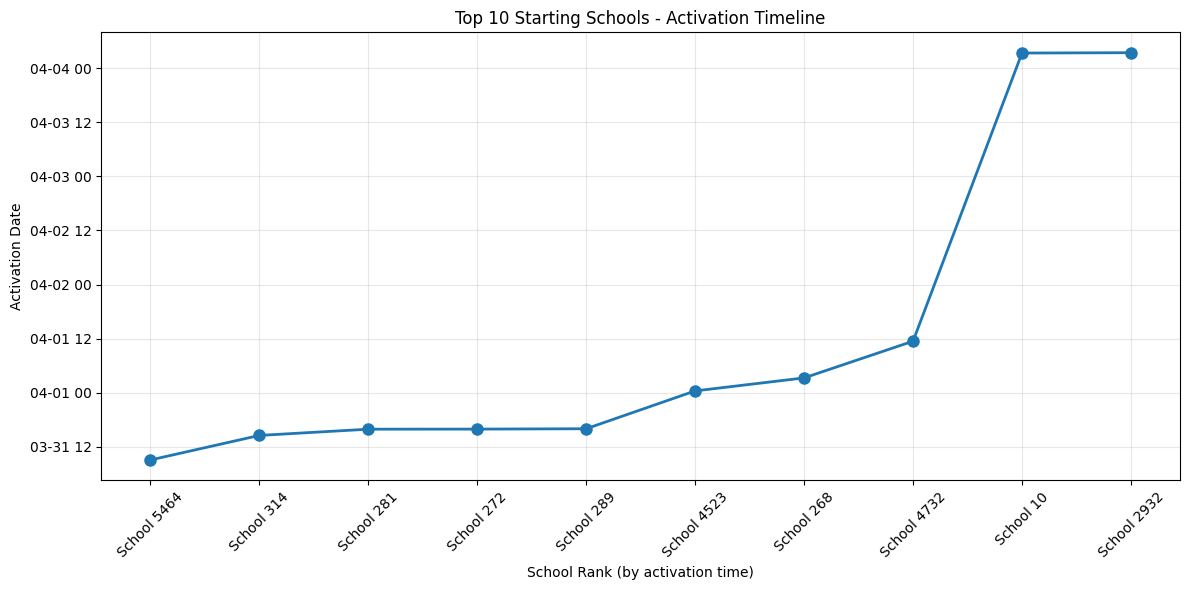


=== 2. DIFFUSION SEQUENCE ANALYSIS ===

Sample Diffusion Chains:
School 5464 → School 4932.0 (Distance: 0.0087, Days: 22)
School 5464 → School 5467.0 (Distance: 0.0107, Days: 40)
School 5464 → School 5459.0 (Distance: 0.0108, Days: 35)
School 5464 → School 4930.0 (Distance: 0.0148, Days: 31)
School 5464 → School 5457.0 (Distance: 0.0168, Days: 35)
School 5464 → School 5454.0 (Distance: 0.0193, Days: 19)
School 5464 → School 5455.0 (Distance: 0.0198, Days: 32)
School 5464 → School 4936.0 (Distance: 0.0234, Days: 34)
School 5464 → School 4926.0 (Distance: 0.0287, Days: 22)
School 314 → School 292.0 (Distance: 0.0277, Days: 18)


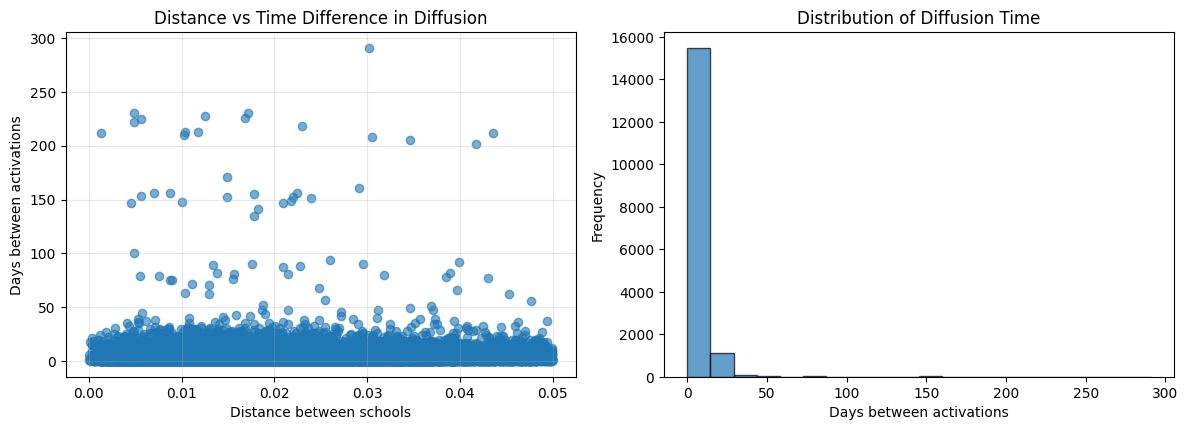


=== 3. DIFFUSION SPEED ANALYSIS ===

Transmission Speed Statistics:
Average transmission time: 6.92 days
Median transmission time: 4.00 days
Min transmission time: 0 days
Max transmission time: 316 days


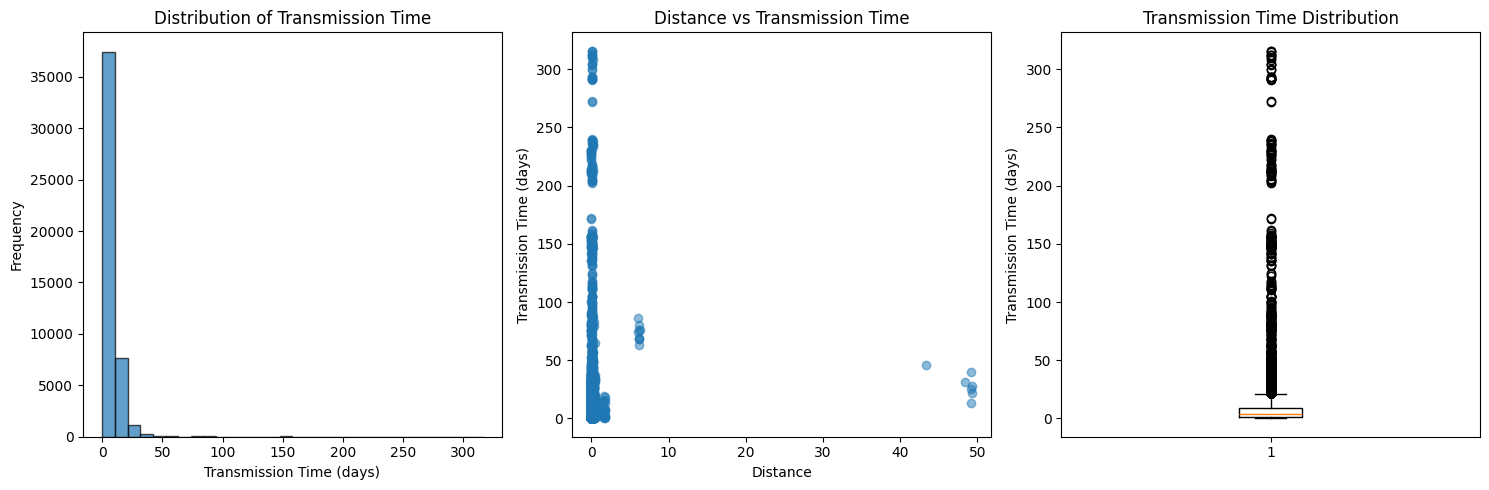


=== 4. GEOGRAPHICAL RELATIONSHIP ANALYSIS ===

Distance Statistics:
count    49693.000000
mean         0.059378
std          0.659904
min          0.000007
25%          0.014358
50%          0.023737
75%          0.067136
max         49.296594
Name: distance, dtype: float64

Geographical Spread Analysis:
     category  count  avg_distance  std_distance
0  Very Close  12236      0.003393      0.003681
1       Close  28175      0.022410      0.009677
2      Medium   7349      0.074242      0.014449
3         Far   7730      0.224087      1.662703


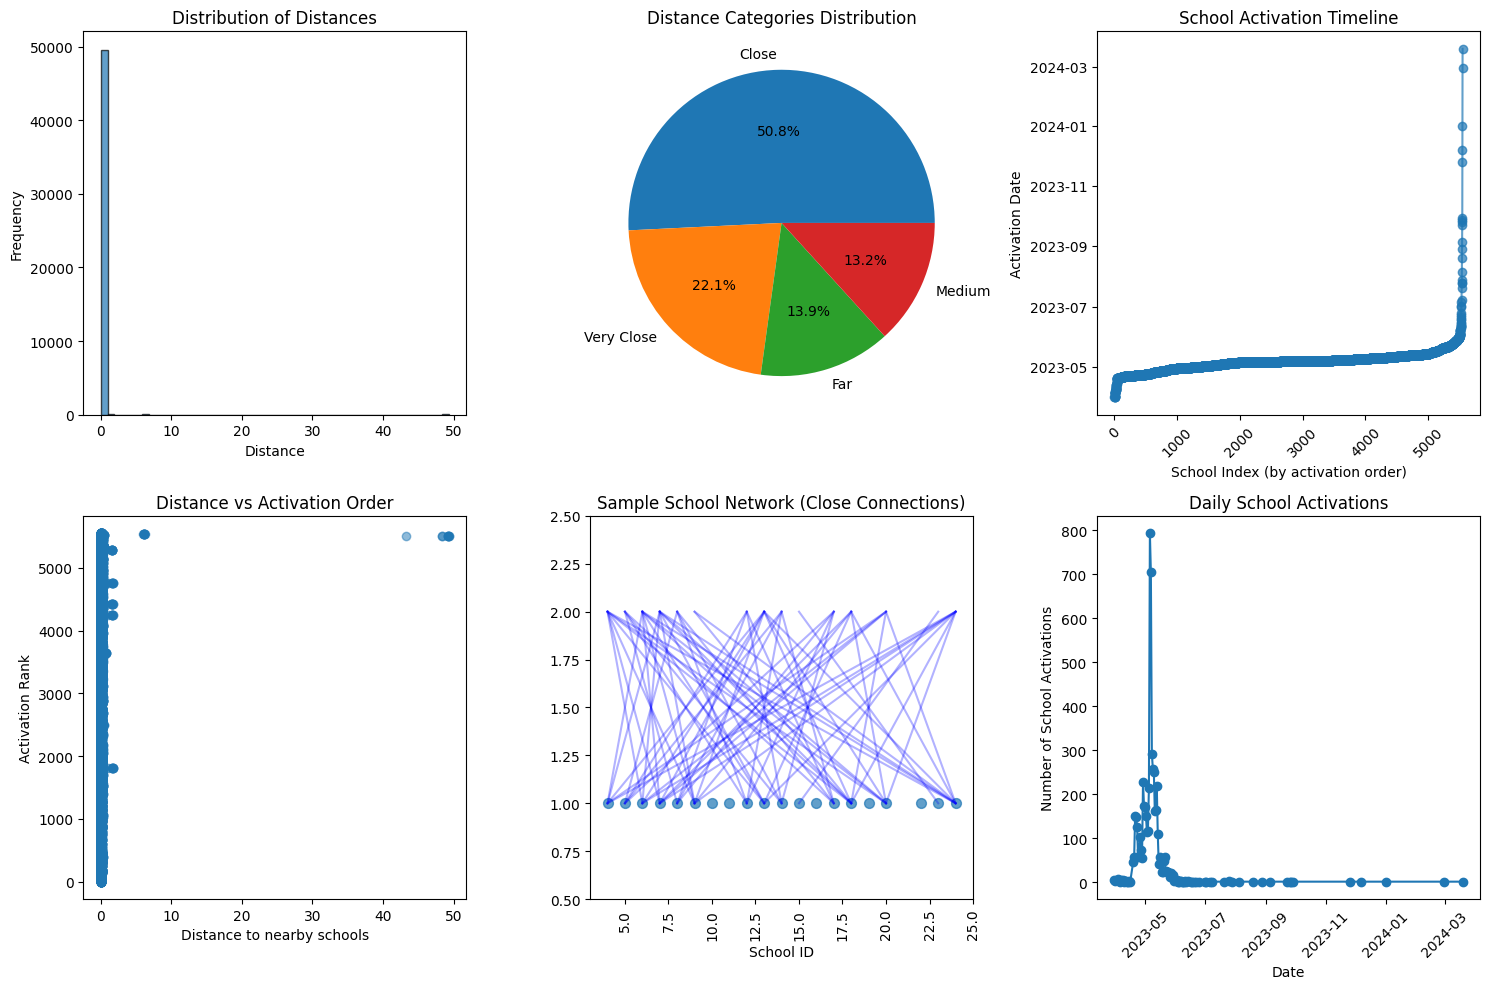


SUMMARY INSIGHTS

1. STARTING SCHOOLS:
   - Analysis identified top 10 starting schools
   - Earliest activation: 2023-03-31 09:05:51.903699
   - Latest in top 10: 2023-04-04 03:23:46.718202

2. DIFFUSION SEQUENCE:
   - Found 16697 potential transmission pairs
   - Average transmission time: 5.4 days
   - Average distance: 0.0194

3. DIFFUSION SPEED:
   - Speed analysis completed for school-to-school transmission

4. GEOGRAPHICAL RELATIONSHIP:
   - Distance categories analyzed
   - Correlation between distance and activation timing examined


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to use English
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def load_and_clean_data(df):
    """Load and clean the dataset by removing missing values"""
    print("Original data shape:", df.shape)
    
    # Remove rows with NaN values
    df_clean = df.dropna()
    print("Data shape after removing NaN:", df_clean.shape)
    
    # Convert created_at to datetime
    df_clean['created_at'] = pd.to_datetime(df_clean['created_at'])
    
    return df_clean

def analyze_starting_schools(df, top_n=10):
    """1. Starting Schools: Find top schools where diffusion began"""
    print("\n=== 1. STARTING SCHOOLS ANALYSIS ===")
    
    # Get earliest activation time for each school
    school_first_activation = df.groupby('school_id')['created_at'].min().reset_index()
    school_first_activation = school_first_activation.sort_values('created_at')
    
    # Top 10 earliest schools
    top_starting_schools = school_first_activation.head(top_n)
    
    print(f"\nTop {top_n} Starting Schools:")
    for i, row in top_starting_schools.iterrows():
        print(f"{row['school_id']}: {row['created_at']}")
    
    # Visualize starting schools timeline
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(top_starting_schools)), 
             top_starting_schools['created_at'], 
             'o-', linewidth=2, markersize=8)
    plt.xlabel('School Rank (by activation time)')
    plt.ylabel('Activation Date')
    plt.title('Top 10 Starting Schools - Activation Timeline')
    plt.xticks(range(len(top_starting_schools)), 
               [f'School {id}' for id in top_starting_schools['school_id']], 
               rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return top_starting_schools

def analyze_diffusion_sequence(df):
    """2. Diffusion Sequence: Track how schools spread to nearby schools"""
    print("\n=== 2. DIFFUSION SEQUENCE ANALYSIS ===")
    
    # Get activation sequence
    school_activation = df.groupby('school_id')['created_at'].min().reset_index()
    school_activation = school_activation.sort_values('created_at')
    
    # Create diffusion chains based on distance data
    diffusion_chains = []
    
    # For each school, find what schools it potentially influenced
    for _, school_row in school_activation.iterrows():
        school_id = school_row['school_id']
        activation_time = school_row['created_at']
        
        # Find schools that were activated later and are nearby
        nearby_later_schools = df[
            (df['school_id'] == school_id) & 
            (df['distance'] > 0) & 
            (df['distance'] < 0.05)  # Within 5% distance threshold
        ]
        
        if not nearby_later_schools.empty:
            for _, nearby_row in nearby_later_schools.iterrows():
                nearby_school_id = nearby_row['nearby_school_id']
                nearby_activation = school_activation[
                    school_activation['school_id'] == nearby_school_id
                ]['created_at']
                
                if not nearby_activation.empty:
                    nearby_time = nearby_activation.iloc[0]
                    if nearby_time > activation_time:
                        diffusion_chains.append({
                            'from_school': school_id,
                            'to_school': nearby_school_id,
                            'distance': nearby_row['distance'],
                            'time_diff': (nearby_time - activation_time).days,
                            'from_time': activation_time,
                            'to_time': nearby_time
                        })
    
    diffusion_df = pd.DataFrame(diffusion_chains)
    
    if not diffusion_df.empty:
        print("\nSample Diffusion Chains:")
        sample_chains = diffusion_df.head(10)
        for _, chain in sample_chains.iterrows():
            print(f"School {chain['from_school']} → School {chain['to_school']} "
                  f"(Distance: {chain['distance']:.4f}, Days: {chain['time_diff']})")
        
        # Visualize diffusion network
        plt.figure(figsize=(12, 8))
        
        # Plot 1: Distance vs Time Difference
        plt.subplot(2, 2, 1)
        plt.scatter(diffusion_df['distance'], diffusion_df['time_diff'], alpha=0.6)
        plt.xlabel('Distance between schools')
        plt.ylabel('Days between activations')
        plt.title('Distance vs Time Difference in Diffusion')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Diffusion timeline
        plt.subplot(2, 2, 2)
        plt.hist(diffusion_df['time_diff'], bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Days between activations')
        plt.ylabel('Frequency')
        plt.title('Distribution of Diffusion Time')
        
        plt.tight_layout()
        plt.show()
    
    return diffusion_df

def analyze_diffusion_speed(df):
    """3. Diffusion Speed: Calculate transmission time between schools"""
    print("\n=== 3. DIFFUSION SPEED ANALYSIS ===")
    
    # Calculate speed metrics
    school_activation = df.groupby('school_id')['created_at'].min().reset_index()
    
    # Find transmission pairs
    transmission_data = []
    
    for _, row in df.iterrows():
        if row['distance'] > 0:  # Exclude self-references
            school1_time = school_activation[
                school_activation['school_id'] == row['school_id']
            ]['created_at']
            school2_time = school_activation[
                school_activation['school_id'] == row['nearby_school_id']
            ]['created_at']
            
            if not school1_time.empty and not school2_time.empty:
                time1 = school1_time.iloc[0]
                time2 = school2_time.iloc[0]
                time_diff = abs((time2 - time1).days)
                
                transmission_data.append({
                    'school1': row['school_id'],
                    'school2': row['nearby_school_id'],
                    'distance': row['distance'],
                    'time_diff_days': time_diff,
                    'speed': row['distance'] / max(time_diff, 1)  # Avoid division by zero
                })
    
    transmission_df = pd.DataFrame(transmission_data)
    
    if not transmission_df.empty:
        print(f"\nTransmission Speed Statistics:")
        print(f"Average transmission time: {transmission_df['time_diff_days'].mean():.2f} days")
        print(f"Median transmission time: {transmission_df['time_diff_days'].median():.2f} days")
        print(f"Min transmission time: {transmission_df['time_diff_days'].min()} days")
        print(f"Max transmission time: {transmission_df['time_diff_days'].max()} days")
        
        # Visualize speed analysis
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(transmission_df['time_diff_days'], bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Transmission Time (days)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Transmission Time')
        
        plt.subplot(1, 3, 2)
        plt.scatter(transmission_df['distance'], transmission_df['time_diff_days'], alpha=0.5)
        plt.xlabel('Distance')
        plt.ylabel('Transmission Time (days)')
        plt.title('Distance vs Transmission Time')
        
        plt.subplot(1, 3, 3)
        plt.boxplot(transmission_df['time_diff_days'])
        plt.ylabel('Transmission Time (days)')
        plt.title('Transmission Time Distribution')
        
        plt.tight_layout()
        plt.show()
    
    return transmission_df

def analyze_geographical_relationship(df):
    """4. Geographical Relationship: Analyze if nearby schools spread together"""
    print("\n=== 4. GEOGRAPHICAL RELATIONSHIP ANALYSIS ===")
    
    # Distance-based clustering analysis
    distance_stats = df[df['distance'] > 0]['distance'].describe()
    print("\nDistance Statistics:")
    print(distance_stats)
    
    # Categorize distances
    def categorize_distance(dist):
        if dist <= 0.01:
            return 'Very Close'
        elif dist <= 0.05:
            return 'Close'
        elif dist <= 0.1:
            return 'Medium'
        else:
            return 'Far'
    
    df['distance_category'] = df['distance'].apply(categorize_distance)
    
    # Analyze activation patterns by distance
    school_activation = df.groupby('school_id')['created_at'].min().reset_index()
    
    # Merge with distance data
    df_merged = df.merge(school_activation, on='school_id', suffixes=['', '_activation'])
    
    # Group by distance category
    distance_analysis = []
    for category in ['Very Close', 'Close', 'Medium', 'Far']:
        category_data = df_merged[df_merged['distance_category'] == category]
        if not category_data.empty:
            avg_activation_time = category_data['created_at_activation'].mean()
            count = len(category_data)
            distance_analysis.append({
                'category': category,
                'count': count,
                'avg_distance': category_data['distance'].mean(),
                'std_distance': category_data['distance'].std()
            })
    
    distance_analysis_df = pd.DataFrame(distance_analysis)
    
    print("\nGeographical Spread Analysis:")
    print(distance_analysis_df)
    
    # Visualize geographical relationships
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distance distribution
    plt.subplot(2, 3, 1)
    df_nonzero = df[df['distance'] > 0]
    plt.hist(df_nonzero['distance'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Distances')
    
    # Plot 2: Distance categories
    plt.subplot(2, 3, 2)
    category_counts = df['distance_category'].value_counts()
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    plt.title('Distance Categories Distribution')
    
    # Plot 3: Activation timeline by school
    plt.subplot(2, 3, 3)
    school_activation_sorted = school_activation.sort_values('created_at')
    plt.plot(range(len(school_activation_sorted)), school_activation_sorted['created_at'], 'o-', alpha=0.7)
    plt.xlabel('School Index (by activation order)')
    plt.ylabel('Activation Date')
    plt.title('School Activation Timeline')
    plt.xticks(rotation=45)
    
    # Plot 4: Distance vs Activation time correlation
    plt.subplot(2, 3, 4)
    # Calculate correlation between distance and activation sequence
    school_early_late = school_activation.copy()
    school_early_late['activation_rank'] = school_early_late['created_at'].rank()
    
    # Merge with distance data
    correlation_data = df.merge(school_early_late[['school_id', 'activation_rank']], on='school_id')
    correlation_data = correlation_data[correlation_data['distance'] > 0]
    
    plt.scatter(correlation_data['distance'], correlation_data['activation_rank'], alpha=0.5)
    plt.xlabel('Distance to nearby schools')
    plt.ylabel('Activation Rank')
    plt.title('Distance vs Activation Order')
    
    # Plot 5: Network-style visualization (sample)
    plt.subplot(2, 3, 5)
    sample_schools = school_activation.head(20)['school_id'].tolist()
    sample_data = df[df['school_id'].isin(sample_schools) & df['nearby_school_id'].isin(sample_schools)]
    
    if not sample_data.empty:
        for _, row in sample_data.iterrows():
            if row['distance'] > 0 and row['distance'] < 0.05:  # Only close connections
                plt.plot([row['school_id'], row['nearby_school_id']], 
                        [1, 2], 'b-', alpha=0.3)
        
        plt.scatter(sample_schools, [1]*len(sample_schools), s=50, alpha=0.7)
        plt.ylim(0.5, 2.5)
        plt.xlabel('School ID')
        plt.title('Sample School Network (Close Connections)')
        plt.xticks(rotation=90)
    
    # Plot 6: Time series of activations
    plt.subplot(2, 3, 6)
    daily_activations = school_activation.groupby(school_activation['created_at'].dt.date).size()
    plt.plot(daily_activations.index, daily_activations.values, 'o-')
    plt.xlabel('Date')
    plt.ylabel('Number of School Activations')
    plt.title('Daily School Activations')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return distance_analysis_df, correlation_data

def comprehensive_analysis(df):
    """Run comprehensive analysis of school diffusion patterns"""
    print("COMPREHENSIVE SCHOOL DIFFUSION ANALYSIS")
    print("=" * 50)
    
    # Clean data
    df_clean = load_and_clean_data(df)
    
    # Run all analyses
    starting_schools = analyze_starting_schools(df_clean)
    diffusion_sequence = analyze_diffusion_sequence(df_clean)
    diffusion_speed = analyze_diffusion_speed(df_clean)
    geo_analysis, correlation_data = analyze_geographical_relationship(df_clean)
    
    # Summary insights
    print("\n" + "="*50)
    print("SUMMARY INSIGHTS")
    print("="*50)
    
    print(f"\n1. STARTING SCHOOLS:")
    print(f"   - Analysis identified top 10 starting schools")
    print(f"   - Earliest activation: {starting_schools.iloc[0]['created_at']}")
    print(f"   - Latest in top 10: {starting_schools.iloc[-1]['created_at']}")
    
    if not diffusion_sequence.empty:
        print(f"\n2. DIFFUSION SEQUENCE:")
        print(f"   - Found {len(diffusion_sequence)} potential transmission pairs")
        print(f"   - Average transmission time: {diffusion_sequence['time_diff'].mean():.1f} days")
        print(f"   - Average distance: {diffusion_sequence['distance'].mean():.4f}")
    
    print(f"\n3. DIFFUSION SPEED:")
    print(f"   - Speed analysis completed for school-to-school transmission")
    
    print(f"\n4. GEOGRAPHICAL RELATIONSHIP:")
    print(f"   - Distance categories analyzed")
    print(f"   - Correlation between distance and activation timing examined")
    
    return {
        'starting_schools': starting_schools,
        'diffusion_sequence': diffusion_sequence, 
        'diffusion_speed': diffusion_speed,
        'geographical_analysis': geo_analysis,
        'correlation_data': correlation_data
    }



results = comprehensive_analysis(df)

=== 학교 간 전파 패턴 분석 ===

1. 확산 순서 분석
----------------------------------------
최초 5개 학교의 발생 순서:
  5112순위: 학교 5464 - 2023-03-31 09:05:51
  284순위: 학교 314 - 2023-03-31 14:32:36
  252순위: 학교 281 - 2023-03-31 15:55:48
  244순위: 학교 272 - 2023-03-31 15:56:52
  260순위: 학교 289 - 2023-03-31 16:01:40

2. 확산 속도 분석
----------------------------------------
전파 사례 수: 24075건
평균 전파 소요 일수: 7.07일
최단 전파 시간: 0.00일
최장 전파 시간: 315.13일

3. 지리적 관계 분석
----------------------------------------
거리별 전파 패턴:
                count   mean    std
distance_group                     
매우가까움(<0.01)     3106   5.91  11.49
가까움(0.01-0.05)  13592   5.84  10.57
보통(0.05-0.1)     3523   8.64  18.76
멀음(>0.1)         3731  11.02  19.76

거리와 전파속도 상관관계: 0.0431
→ 약한 상관관계 (지리적 거리의 영향 제한적)


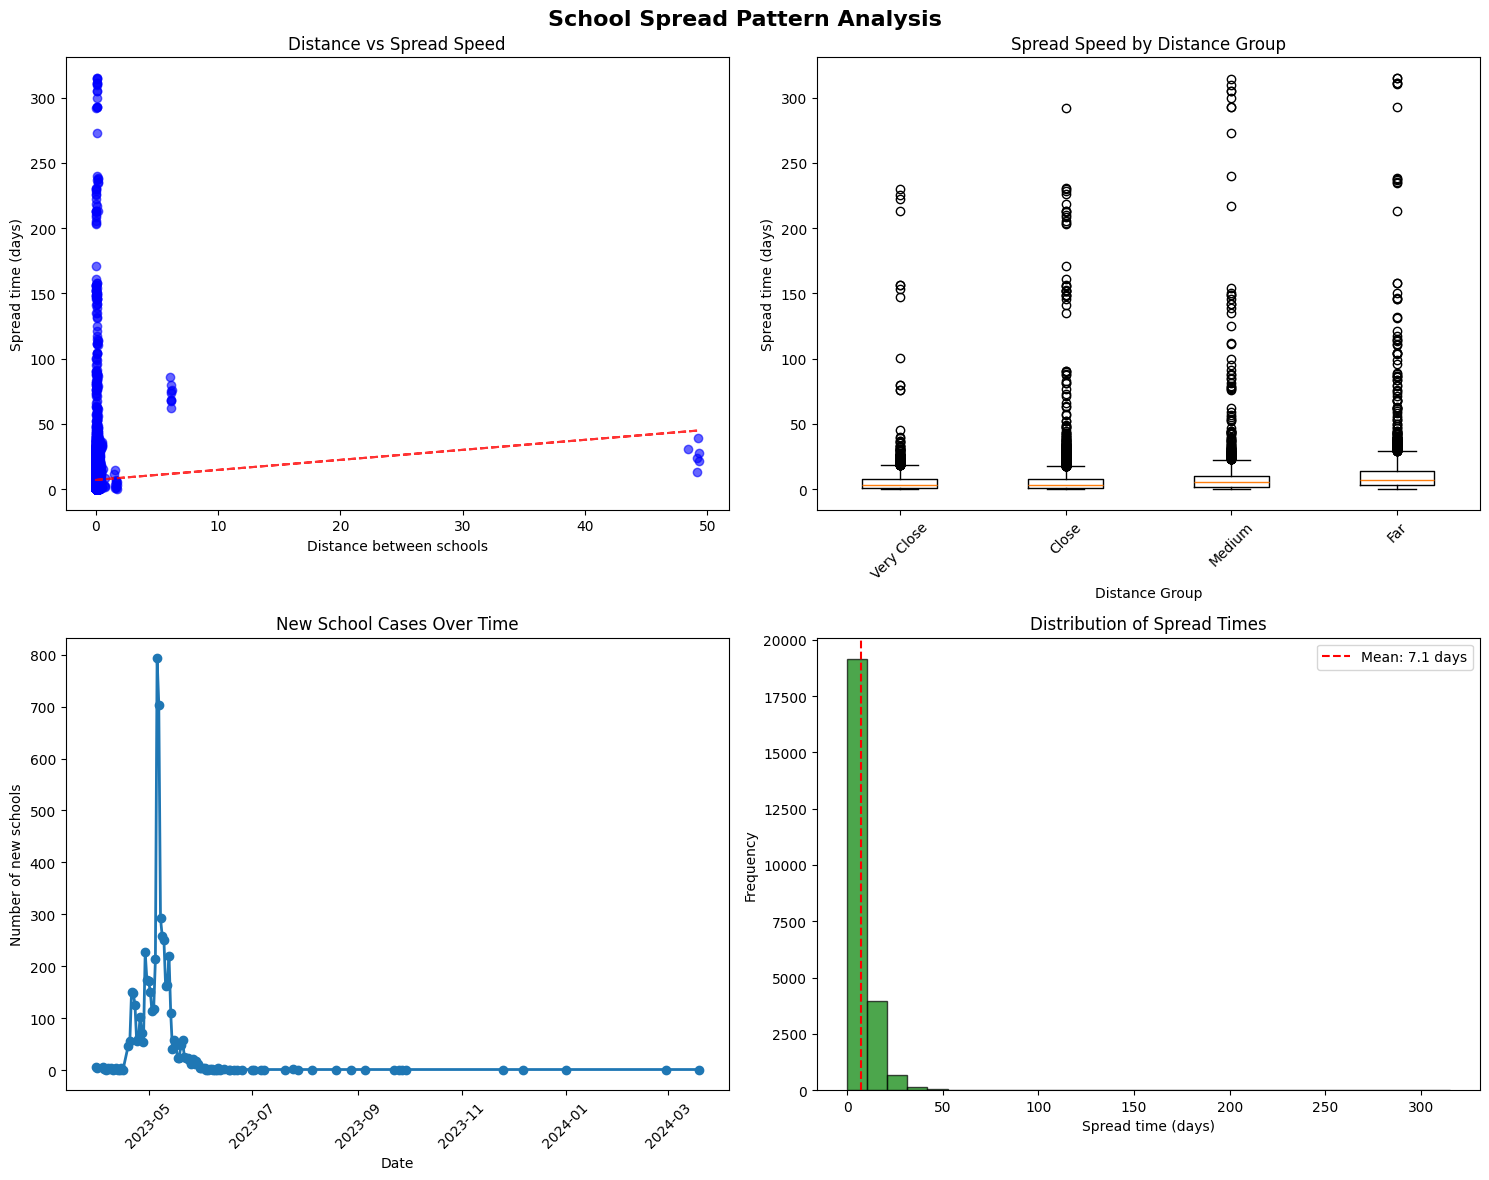


📊 학교 간 전파 패턴 분석 요약 보고서
🏫 전체 학교 수: 5549개
📈 확인된 전파 사례: 24075건
⏱️  평균 전파 소요 시간: 7.1일
🗺️  거리-전파속도 상관계수: 0.043

📏 거리별 전파 패턴:
   Very Close: 3106.0건, 평균 5.9일
   Close: 13592.0건, 평균 5.8일
   Medium: 3523.0건, 평균 8.6일
   Far: 3731.0건, 평균 11.0일

🎯 결론:
   • 지리적 거리와 전파 속도 간 뚜렷한 관계 없음
   • 다른 요인들이 전파에 더 큰 영향을 미칠 가능성
샘플 데이터로 분석을 실행하려면 실제 데이터를 로드하세요.
df = pd.read_csv('your_file.csv')
spread_df, school_df = analyze_school_spread_pattern(df)
visualize_spread_pattern(spread_df, school_df)
generate_summary_report(spread_df, school_df)


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def analyze_school_spread_pattern(df):
    """
    학교 간 전파 패턴 분석 함수
    """
    # 데이터 전처리
    df = df.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.dropna(subset=['distance', 'nearby_school_id', 'school_id'])
    
    print("=== 학교 간 전파 패턴 분석 ===\n")
    
    # 1. 확산 순서 분석
    print("1. 확산 순서 분석")
    print("-" * 40)
    
    # 학교별 최초 발생 시간 계산
    school_first_occurrence = df.groupby('school_id')['created_at'].min().reset_index()
    school_first_occurrence.columns = ['school_id', 'first_occurrence']
    school_first_occurrence = school_first_occurrence.sort_values('first_occurrence')
    
    print("최초 5개 학교의 발생 순서:")
    for i, row in school_first_occurrence.head().iterrows():
        print(f"  {i+1}순위: 학교 {row['school_id']} - {row['first_occurrence'].strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 2. 확산 속도 분석
    print(f"\n2. 확산 속도 분석")
    print("-" * 40)
    
    # 학교 쌍별 전파 시간 계산
    spread_analysis = []
    
    for _, row in df.iterrows():
        if row['nearby_school_id'] != row['school_id']:  # 자기 자신 제외
            # 근처 학교의 최초 발생 시간
            nearby_first = school_first_occurrence[
                school_first_occurrence['school_id'] == row['nearby_school_id']
            ]['first_occurrence']
            
            # 현재 학교의 최초 발생 시간
            current_first = school_first_occurrence[
                school_first_occurrence['school_id'] == row['school_id']
            ]['first_occurrence']
            
            if len(nearby_first) > 0 and len(current_first) > 0:
                time_diff = (current_first.iloc[0] - nearby_first.iloc[0]).total_seconds() / (24 * 3600)  # 일 단위
                
                if time_diff > 0:  # 근처 학교가 먼저 발생한 경우만
                    spread_analysis.append({
                        'from_school': row['nearby_school_id'],
                        'to_school': row['school_id'],
                        'distance': row['distance'],
                        'spread_days': time_diff,
                        'record_time': row['created_at']
                    })
    
    spread_df = pd.DataFrame(spread_analysis)
    
    if len(spread_df) > 0:
        print(f"전파 사례 수: {len(spread_df)}건")
        print(f"평균 전파 소요 일수: {spread_df['spread_days'].mean():.2f}일")
        print(f"최단 전파 시간: {spread_df['spread_days'].min():.2f}일")
        print(f"최장 전파 시간: {spread_df['spread_days'].max():.2f}일")
        
        # 3. 지리적 관계 분석
        print(f"\n3. 지리적 관계 분석")
        print("-" * 40)
        
        # 거리별 구간 나누기
        spread_df['distance_group'] = pd.cut(spread_df['distance'], 
                                           bins=[0, 0.01, 0.05, 0.1, float('inf')],
                                           labels=['매우가까움(<0.01)', '가까움(0.01-0.05)', 
                                                  '보통(0.05-0.1)', '멀음(>0.1)'])
        
        # 거리별 전파 속도 분석
        distance_speed = spread_df.groupby('distance_group')['spread_days'].agg(['count', 'mean', 'std']).round(2)
        print("거리별 전파 패턴:")
        print(distance_speed)
        
        # 상관관계 분석
        correlation = spread_df['distance'].corr(spread_df['spread_days'])
        print(f"\n거리와 전파속도 상관관계: {correlation:.4f}")
        
        if abs(correlation) > 0.3:
            relationship = "강한 상관관계" if abs(correlation) > 0.5 else "중간 상관관계"
            direction = "양의" if correlation > 0 else "음의"
            print(f"→ {direction} {relationship} 존재 (거리가 {'멀수록' if correlation > 0 else '가까울수록'} 전파가 {'느림' if correlation > 0 else '빠름'})")
        else:
            print("→ 약한 상관관계 (지리적 거리의 영향 제한적)")
        
        return spread_df, school_first_occurrence
    else:
        print("분석 가능한 전파 사례가 없습니다.")
        return None, school_first_occurrence

def visualize_spread_pattern(spread_df, school_first_occurrence):
    """
    전파 패턴 시각화
    """
    if spread_df is None or len(spread_df) == 0:
        print("시각화할 데이터가 없습니다.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('School Spread Pattern Analysis', fontsize=16, fontweight='bold')
    
    # 1. 거리 vs 전파속도 산점도
    axes[0,0].scatter(spread_df['distance'], spread_df['spread_days'], alpha=0.6, color='blue')
    axes[0,0].set_xlabel('Distance between schools')
    axes[0,0].set_ylabel('Spread time (days)')
    axes[0,0].set_title('Distance vs Spread Speed')
    
    # 추세선 추가
    z = np.polyfit(spread_df['distance'], spread_df['spread_days'], 1)
    p = np.poly1d(z)
    axes[0,0].plot(spread_df['distance'], p(spread_df['distance']), "r--", alpha=0.8)
    
    # 2. 거리별 전파속도 박스플롯
    spread_df['distance_group'] = pd.cut(spread_df['distance'], 
                                       bins=[0, 0.01, 0.05, 0.1, float('inf')],
                                       labels=['Very Close', 'Close', 'Medium', 'Far'])
    
    box_data = [spread_df[spread_df['distance_group'] == group]['spread_days'].dropna() 
                for group in spread_df['distance_group'].cat.categories]
    
    axes[0,1].boxplot(box_data, labels=spread_df['distance_group'].cat.categories)
    axes[0,1].set_xlabel('Distance Group')
    axes[0,1].set_ylabel('Spread time (days)')
    axes[0,1].set_title('Spread Speed by Distance Group')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. 시간별 학교 발생 패턴
    school_first_occurrence['day'] = school_first_occurrence['first_occurrence'].dt.date
    daily_schools = school_first_occurrence.groupby('day').size()
    
    axes[1,0].plot(daily_schools.index, daily_schools.values, marker='o', linewidth=2)
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Number of new schools')
    axes[1,0].set_title('New School Cases Over Time')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. 전파속도 히스토그램
    axes[1,1].hist(spread_df['spread_days'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1,1].axvline(spread_df['spread_days'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {spread_df["spread_days"].mean():.1f} days')
    axes[1,1].set_xlabel('Spread time (days)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Spread Times')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_summary_report(spread_df, school_first_occurrence):
    """
    분석 결과 요약 보고서 생성
    """
    print("\n" + "="*60)
    print("📊 학교 간 전파 패턴 분석 요약 보고서")
    print("="*60)
    
    if spread_df is not None and len(spread_df) > 0:
        # 기본 통계
        total_schools = len(school_first_occurrence)
        total_spread_cases = len(spread_df)
        avg_spread_time = spread_df['spread_days'].mean()
        
        print(f"🏫 전체 학교 수: {total_schools}개")
        print(f"📈 확인된 전파 사례: {total_spread_cases}건")
        print(f"⏱️  평균 전파 소요 시간: {avg_spread_time:.1f}일")
        
        # 지리적 영향 분석
        correlation = spread_df['distance'].corr(spread_df['spread_days'])
        print(f"🗺️  거리-전파속도 상관계수: {correlation:.3f}")
        
        # 거리별 그룹 분석
        distance_groups = spread_df.groupby('distance_group')['spread_days'].agg(['count', 'mean'])
        print(f"\n📏 거리별 전파 패턴:")
        for group, data in distance_groups.iterrows():
            print(f"   {group}: {data['count']}건, 평균 {data['mean']:.1f}일")
        
        # 결론
        print(f"\n🎯 결론:")
        if abs(correlation) > 0.3:
            if correlation > 0:
                print("   • 거리가 멀수록 전파가 느려지는 경향 확인")
                print("   • 지리적 근접성이 전파 속도에 영향을 미침")
            else:
                print("   • 거리가 가까울수록 전파가 느려지는 특이한 패턴")
                print("   • 추가 요인 분석 필요")
        else:
            print("   • 지리적 거리와 전파 속도 간 뚜렷한 관계 없음")
            print("   • 다른 요인들이 전파에 더 큰 영향을 미칠 가능성")
    else:
        print("❌ 분석 가능한 전파 데이터가 부족합니다.")

# 메인 실행 함수
def main():
    """
    메인 분석 실행 함수
    
    사용법:
    1. 데이터를 pandas DataFrame으로 로드
    2. main() 함수 호출하여 분석 실행
    """
    
    # 예시 데이터 로드 (실제 사용시에는 아래 주석을 해제하고 파일 경로 지정)
    # df = pd.read_csv('your_data.csv')
    
    # 샘플 데이터로 테스트하는 경우:
    print("샘플 데이터로 분석을 실행하려면 실제 데이터를 로드하세요.")
    print("df = pd.read_csv('your_file.csv')")
    print("spread_df, school_df = analyze_school_spread_pattern(df)")
    print("visualize_spread_pattern(spread_df, school_df)")
    print("generate_summary_report(spread_df, school_df)")

if __name__ == "__main__":
    # 실제 데이터 분석 예시
    
    # 분석 실행
    spread_df, school_first_occurrence = analyze_school_spread_pattern(df)
    
    # 시각화
    visualize_spread_pattern(spread_df, school_first_occurrence)
    
    # 요약 보고서
    generate_summary_report(spread_df, school_first_occurrence)
    
    main()

학교 간 전파 패턴 분석을 시작합니다...
=== 데이터 전처리 ===
전체 데이터: 55492 행
분석 가능한 데이터: 55490 행
지역 수: 28
학교 타입: ['H' 'M']

=== 확산 순서 분석 ===
확산 순서 (처음 10개 학교):
   순서  school_id region school_type_name  student_count  \
0   1       5464    경기도             고등학교          158.0   
1   2        314   충청남도             고등학교          131.0   
2   3        281   충청남도             고등학교          347.0   
3   4        272   충청남도             고등학교          339.0   
4   5        289   충청남도             고등학교          385.0   
5   6       4523    경기도             고등학교           92.0   
6   7        268   충청남도             고등학교          236.0   
7   8       4732    경기도             고등학교          220.0   
8   9         10   충청북도              중학교          159.0   
9  10       2932  부산광역시              중학교           57.0   

            first_occurrence  
0 2023-03-31 09:05:51.903699  
1 2023-03-31 14:32:36.425315  
2 2023-03-31 15:55:48.870381  
3 2023-03-31 15:56:52.300066  
4 2023-03-31 16:01:40.796317  
5 2023-04-01 00:24:59.710

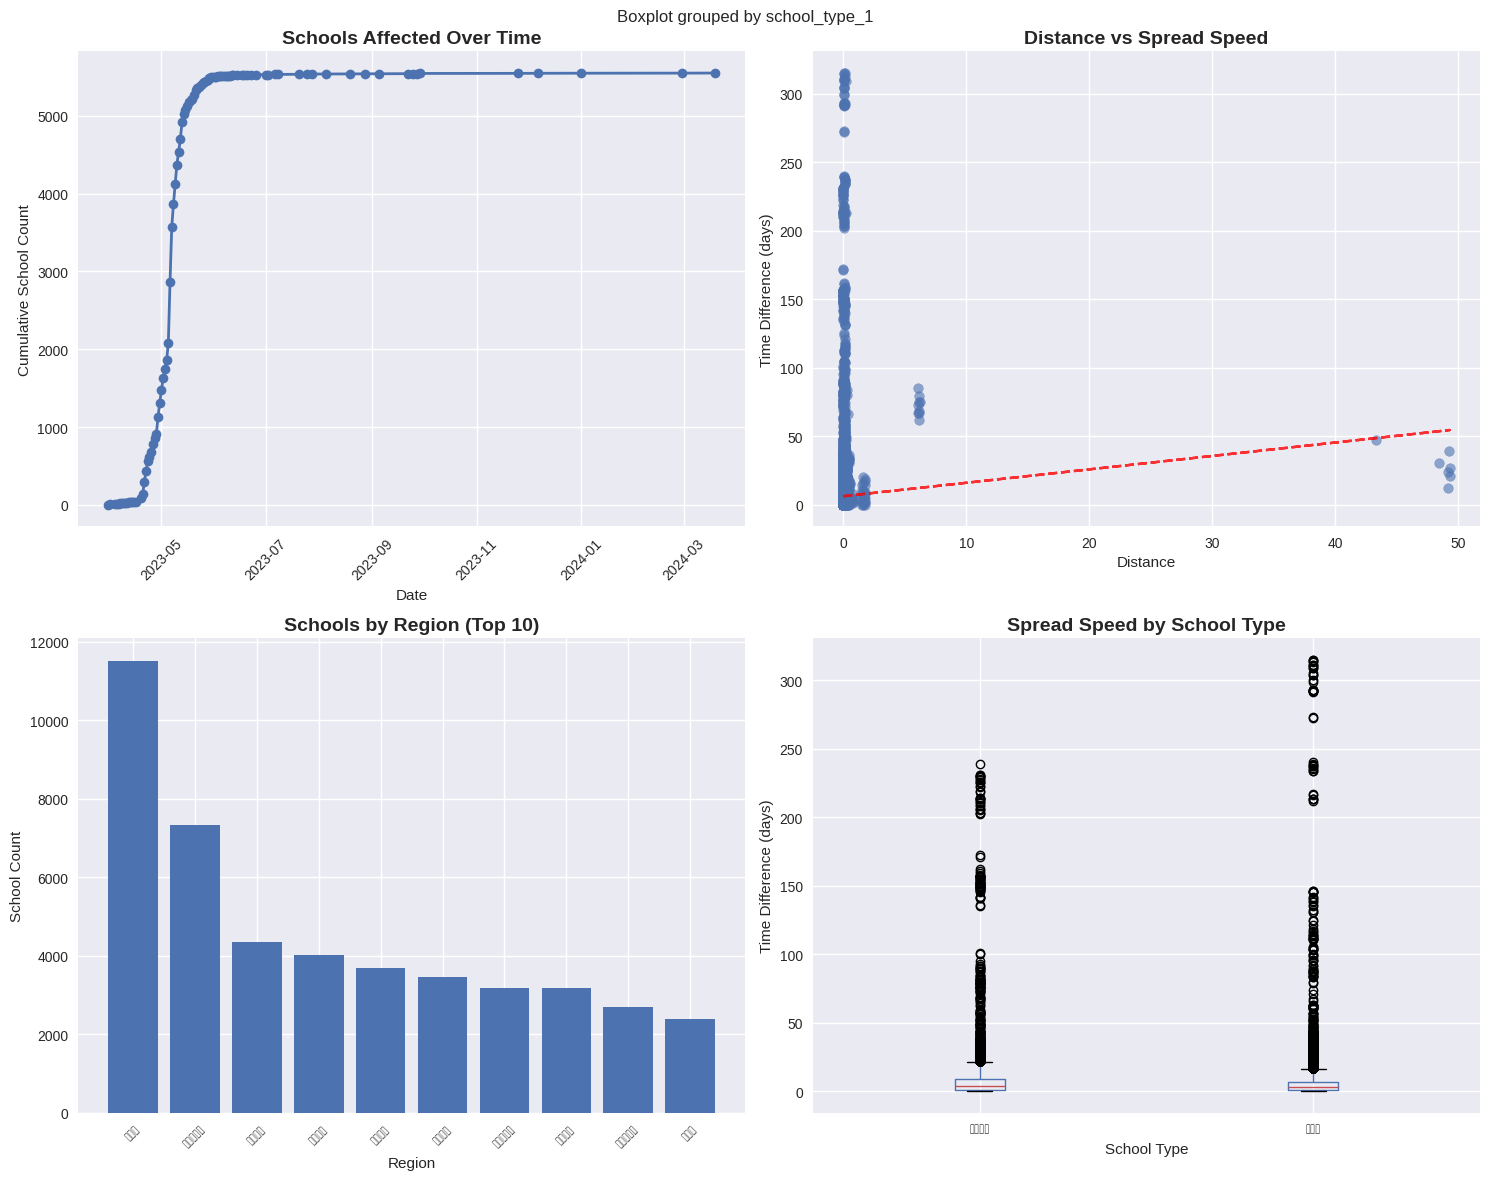


=== 분석 결과 요약 ===
1. 확산 순서: 시간순으로 학교별 첫 발생 시점 확인
2. 확산 속도: 인접 학교 간 전파 소요 일수 계산
3. 지리적 관계: 거리와 전파 속도의 상관관계 분석
4. 영향 요인: 지역, 학교 타입, 학생 수에 따른 전파 패턴 차이 분석

=== 추가 분석 ===
학생 수별 전파 속도:
  student_category_1      mean  count
0          소규모(<100)  7.404570  24903
1       중규모(100-500)  5.052837  27689
2      대규모(500-1000)  4.945946     37
3        초대규모(>1000)       NaN      0

네트워크 분석:
총 학교 수: 5549
연결된 학교 쌍: 52637

월별 신규 학교 수:
      month  school_id
0   2023-03          5
1   2023-04       1305
2   2023-05       4186
3   2023-06         32
4   2023-07          8
5   2023-08          3
6   2023-09          5
7   2023-11          1
8   2023-12          1
9   2024-01          1
10  2024-02          1
11  2024-03          1


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def analyze_school_spread_pattern(df):
    """
    학교 간 전파 패턴 분석 함수
    """
    
    # 1. 데이터 전처리
    print("=== 데이터 전처리 ===")
    
    # NaN 값이 있는 행 제거
    df_clean = df.dropna(subset=['school_id', 'address', 'student_count', 'school_type', 'distance', 'nearby_school_id'])
    
    # created_at을 datetime으로 변환
    df_clean['created_at'] = pd.to_datetime(df_clean['created_at'])
    
    # 지역 정보 추출 (시/도 단위)
    df_clean['region'] = df_clean['address'].str.split().str[0]
    
    # 학교 타입 매핑
    school_type_map = {'H': '고등학교', 'M': '중학교', 'E': '초등학교'}
    df_clean['school_type_name'] = df_clean['school_type'].map(school_type_map).fillna(df_clean['school_type'])
    
    print(f"전체 데이터: {len(df)} 행")
    print(f"분석 가능한 데이터: {len(df_clean)} 행")
    print(f"지역 수: {df_clean['region'].nunique()}")
    print(f"학교 타입: {df_clean['school_type'].unique()}")
    
    return df_clean

def analyze_spread_sequence(df):
    """
    확산 순서 분석
    """
    print("\n=== 확산 순서 분석 ===")
    
    # 각 학교별 첫 발생 시점 계산
    first_occurrence = df.groupby('school_id')['created_at'].min().reset_index()
    first_occurrence.columns = ['school_id', 'first_occurrence']
    
    # 학교 정보와 병합
    school_info = df.drop_duplicates('school_id')[['school_id', 'address', 'student_count', 'school_type_name', 'region']]
    spread_timeline = first_occurrence.merge(school_info, on='school_id')
    
    # 시간순 정렬
    spread_timeline = spread_timeline.sort_values('first_occurrence').reset_index(drop=True)
    spread_timeline['순서'] = range(1, len(spread_timeline) + 1)
    
    print("확산 순서 (처음 10개 학교):")
    print(spread_timeline[['순서', 'school_id', 'region', 'school_type_name', 'student_count', 'first_occurrence']].head(10))
    
    return spread_timeline

def analyze_spread_speed(df):
    """
    확산 속도 분석
    """
    print("\n=== 확산 속도 분석 ===")
    
    # 인접 학교 간 전파 속도 계산
    spread_pairs = []
    
    for _, row in df.iterrows():
        school_id = row['school_id']
        nearby_id = row['nearby_school_id']
        distance = row['distance']
        
        # 두 학교의 첫 발생 시점 찾기
        school_time = df[df['school_id'] == school_id]['created_at'].min()
        nearby_time = df[df['school_id'] == nearby_id]['created_at'].min()
        
        if pd.notna(school_time) and pd.notna(nearby_time):
            time_diff = abs((school_time - nearby_time).days)
            
            spread_pairs.append({
                'school_1': school_id,
                'school_2': nearby_id,
                'distance': distance,
                'time_diff_days': time_diff,
                'earlier_school': school_id if school_time < nearby_time else nearby_id,
                'later_school': nearby_id if school_time < nearby_time else school_id
            })
    
    spread_df = pd.DataFrame(spread_pairs)
    
    if len(spread_df) > 0:
        print(f"분석된 학교 쌍: {len(spread_df)}개")
        print(f"평균 전파 소요 일수: {spread_df['time_diff_days'].mean():.1f}일")
        print(f"평균 거리: {spread_df['distance'].mean():.4f}")
        
        # 거리별 전파 속도 상관관계
        correlation = spread_df['distance'].corr(spread_df['time_diff_days'])
        print(f"거리-전파속도 상관계수: {correlation:.3f}")
    
    return spread_df

def analyze_geographic_influence(df, spread_df):
    """
    지리적 영향 분석
    """
    print("\n=== 지리적 영향 분석 ===")
    
    # 거리 구간별 분석
    if len(spread_df) > 0:
        spread_df['distance_category'] = pd.cut(spread_df['distance'], 
                                               bins=[0, 0.01, 0.05, 0.1, float('inf')],
                                               labels=['매우 가까움(<0.01)', '가까움(0.01-0.05)', '보통(0.05-0.1)', '멀음(>0.1)'])
        
        distance_analysis = spread_df.groupby('distance_category')['time_diff_days'].agg(['mean', 'count']).reset_index()
        print("\n거리별 전파 속도:")
        print(distance_analysis)
        
        # 지역별 전파 패턴
        region_analysis = df.groupby('region').agg({
            'school_id': 'nunique',
            'created_at': ['min', 'max'],
            'student_count': 'mean'
        }).round(2)
        
        print("\n지역별 전파 패턴:")
        print(region_analysis.head(10))
    
    return spread_df

def analyze_factors_affecting_speed(df, spread_df):
    """
    전파 속도에 영향을 미치는 요인 분석
    """
    print("\n=== 전파 속도 영향 요인 분석 ===")
    
    # 학교 정보 추가
    school_info = df.drop_duplicates('school_id')[['school_id', 'student_count', 'school_type_name', 'region']]
    
    # 각 학교 쌍에 대한 정보 추가
    spread_with_info = spread_df.copy()
    
    # 학교 1 정보 추가
    spread_with_info = spread_with_info.merge(
        school_info.rename(columns={'school_id': 'school_1', 'student_count': 'student_count_1', 
                                   'school_type_name': 'school_type_1', 'region': 'region_1'}),
        on='school_1', how='left'
    )
    
    # 학교 2 정보 추가
    spread_with_info = spread_with_info.merge(
        school_info.rename(columns={'school_id': 'school_2', 'student_count': 'student_count_2', 
                                   'school_type_name': 'school_type_2', 'region': 'region_2'}),
        on='school_2', how='left'
    )
    
    # 같은 지역 여부
    spread_with_info['same_region'] = spread_with_info['region_1'] == spread_with_info['region_2']
    
    # 학교 타입 같음 여부
    spread_with_info['same_school_type'] = spread_with_info['school_type_1'] == spread_with_info['school_type_2']
    
    # 학생 수 차이
    spread_with_info['student_diff'] = abs(spread_with_info['student_count_1'] - spread_with_info['student_count_2'])
    
    if len(spread_with_info) > 0:
        # 분석 결과
        print("1. 같은 지역 vs 다른 지역:")
        same_region_analysis = spread_with_info.groupby('same_region')['time_diff_days'].agg(['mean', 'count'])
        print(same_region_analysis)
        
        print("\n2. 같은 학교 타입 vs 다른 학교 타입:")
        same_type_analysis = spread_with_info.groupby('same_school_type')['time_diff_days'].agg(['mean', 'count'])
        print(same_type_analysis)
        
        print("\n3. 학교 타입별 전파 속도:")
        type_analysis = spread_with_info.groupby('school_type_1')['time_diff_days'].agg(['mean', 'count'])
        print(type_analysis)
    
    return spread_with_info

def create_visualizations(df, spread_df, spread_with_info):
    """
    시각화 생성
    """
    print("\n=== 시각화 생성 ===")
    
    # 그래프 스타일 설정
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 시간별 학교 수 증가 추이
    df_time = df.groupby(df['created_at'].dt.date)['school_id'].nunique().cumsum().reset_index()
    axes[0,0].plot(df_time['created_at'], df_time['school_id'], marker='o', linewidth=2)
    axes[0,0].set_title('Schools Affected Over Time', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Cumulative School Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. 거리별 전파 속도
    if len(spread_df) > 0:
        axes[0,1].scatter(spread_df['distance'], spread_df['time_diff_days'], alpha=0.6)
        axes[0,1].set_title('Distance vs Spread Speed', fontsize=14, fontweight='bold')
        axes[0,1].set_xlabel('Distance')
        axes[0,1].set_ylabel('Time Difference (days)')
        
        # 추세선 추가
        z = np.polyfit(spread_df['distance'], spread_df['time_diff_days'], 1)
        p = np.poly1d(z)
        axes[0,1].plot(spread_df['distance'], p(spread_df['distance']), "r--", alpha=0.8)
    
    # 3. 지역별 학교 수
    region_counts = df['region'].value_counts().head(10)
    axes[1,0].bar(range(len(region_counts)), region_counts.values)
    axes[1,0].set_title('Schools by Region (Top 10)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Region')
    axes[1,0].set_ylabel('School Count')
    axes[1,0].set_xticks(range(len(region_counts)))
    axes[1,0].set_xticklabels(region_counts.index, rotation=45)
    
    # 4. 학교 타입별 전파 속도
    if len(spread_with_info) > 0 and 'school_type_1' in spread_with_info.columns:
        spread_with_info.boxplot(column='time_diff_days', by='school_type_1', ax=axes[1,1])
        axes[1,1].set_title('Spread Speed by School Type', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('School Type')
        axes[1,1].set_ylabel('Time Difference (days)')
    
    plt.tight_layout()
    plt.show()

def main_analysis(df):
    """
    메인 분석 함수
    """
    print("학교 간 전파 패턴 분석을 시작합니다...")
    
    # 1. 데이터 전처리
    df_clean = analyze_school_spread_pattern(df)
    
    # 2. 확산 순서 분석
    spread_timeline = analyze_spread_sequence(df_clean)
    
    # 3. 확산 속도 분석
    spread_df = analyze_spread_speed(df_clean)
    
    # 4. 지리적 영향 분석
    spread_df = analyze_geographic_influence(df_clean, spread_df)
    
    # 5. 전파 속도 영향 요인 분석
    spread_with_info = analyze_factors_affecting_speed(df_clean, spread_df)
    
    # 6. 시각화
    create_visualizations(df_clean, spread_df, spread_with_info)
    
    # 7. 종합 결과 요약
    print("\n=== 분석 결과 요약 ===")
    print("1. 확산 순서: 시간순으로 학교별 첫 발생 시점 확인")
    print("2. 확산 속도: 인접 학교 간 전파 소요 일수 계산")
    print("3. 지리적 관계: 거리와 전파 속도의 상관관계 분석")
    print("4. 영향 요인: 지역, 학교 타입, 학생 수에 따른 전파 패턴 차이 분석")
    
    return {
        'clean_data': df_clean,
        'spread_timeline': spread_timeline,
        'spread_pairs': spread_df,
        'detailed_analysis': spread_with_info
    }

# 사용 예시:
# df = pd.read_csv('your_data.csv')  # 데이터 로드
# results = main_analysis(df)

# 추가 분석이 필요한 경우:
def additional_analysis(results):
    """
    추가 분석 함수
    """
    df_clean = results['clean_data']
    spread_with_info = results['detailed_analysis']
    
    print("\n=== 추가 분석 ===")
    
    # 1. 학생 수 구간별 분석
    if len(spread_with_info) > 0:
        # 학생 수 구간화
        spread_with_info['student_category_1'] = pd.cut(spread_with_info['student_count_1'], 
                                                       bins=[0, 100, 500, 1000, float('inf')],
                                                       labels=['소규모(<100)', '중규모(100-500)', '대규모(500-1000)', '초대규모(>1000)'])
        
        student_analysis = spread_with_info.groupby('student_category_1')['time_diff_days'].agg(['mean', 'count']).reset_index()
        print("학생 수별 전파 속도:")
        print(student_analysis)
    
    # 2. 네트워크 분석 (간단한 연결성 분석)
    print(f"\n네트워크 분석:")
    print(f"총 학교 수: {df_clean['school_id'].nunique()}")
    print(f"연결된 학교 쌍: {len(spread_with_info)}")
    
    # 3. 시기별 전파 패턴
    df_clean['month'] = df_clean['created_at'].dt.to_period('M')
    monthly_pattern = df_clean.groupby('month')['school_id'].nunique().reset_index()
    print(f"\n월별 신규 학교 수:")
    print(monthly_pattern)


results = main_analysis(df)
additional_analysis(results)

- '확산_속도': 평균 전파 일수는 약 6.92일이고 중앙값은 4일이다
- '지리적_관계': 지리적으로 가까운 학교끼리 퍼지긴 했습니다
- 사용자의 가입 시기별 학교 위치

#### hackle

##### hackle_properties

In [ ]:
hackle_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_properties.parquet', engine='pyarrow')

##### hackle_device_properties

In [ ]:
hackle_device_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_device_properties.parquet', engine='pyarrow')

##### hackle_events

In [ ]:
hackle_events = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_events.parquet', engine='pyarrow')

In [ ]:
hackle_events.head(5)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN


In [ ]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


In [ ]:
hackle_events.sort_values(by='event_datetime',ascending=False)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
142242,032f9cbe-1f2c-49cb-813c-fab7b0af0e2c,2023-08-10 23:59:59,click_profile_ask,YIueYsYZ4RcK8gU8RpJgBp5eM6r2,032f9cbe-1f2c-49cb-813c-fab7b0af0e2c,,profile,24.0,158.0,2005.0,NaN
6431837,8fdbf864-5ca1-4c04-9c1d-65cfa77fb785,2023-08-10 23:59:59,click_question_open,SLYS6VZW3BhfBIh5voiWn8qP0Eq1,8fdbf864-5ca1-4c04-9c1d-65cfa77fb785,,,36.0,472.0,2866.0,NaN
5570349,7c9112c0-31e1-4383-9e83-01f33243482f,2023-08-10 23:59:59,click_question_open,K8dB0xPz3agq6TEHj4tckYuhdsX2,7c9112c0-31e1-4383-9e83-01f33243482f,,,47.0,108.0,3447.0,NaN
3271143,4927213d-746c-4aba-840a-feb9d89a6c83,2023-08-10 23:59:59,click_appbar_alarm_center,3DCF1FB2-1CD8-4D65-AD84-A5A452D9B79F,4927213d-746c-4aba-840a-feb9d89a6c83,,,100.0,436.0,56.0,NaN
4346758,6130a275-a7c0-49e2-8a77-c2c65b7bac57,2023-08-10 23:59:58,complete_question,odk8RTCajuUL1uDHK5DHie0W09j2,6130a275-a7c0-49e2-8a77-c2c65b7bac57,,,74.0,396.0,3903.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5888102,83af0e6a-9e3b-4e2f-bc85-562c32f58861,2023-07-18 00:00:00,launch_app,2ACAE228-B8FC-453A-8876-A686904DA890,83af0e6a-9e3b-4e2f-bc85-562c32f58861,,,45.0,89.0,383.0,NaN
9298767,d0091b70-8c50-4492-883e-c088357705b9,2023-07-18 00:00:00,view_lab_tap,KWiNttJfyuP1jsVCCQVNSl5M4pj2,d0091b70-8c50-4492-883e-c088357705b9,,,78.0,461.0,70.0,NaN
8255004,b8b5a1e2-6249-48e0-9f36-c6c53281e609,2023-07-18 00:00:00,click_question_ask,BVOhOfPTHcQ69uVzaOARsHzr1IJ3,b8b5a1e2-6249-48e0-9f36-c6c53281e609,,home,87.0,340.0,2710.0,NaN
2619909,3a9847c9-12a5-4d2b-9582-e3fbaca95a8f,2023-07-18 00:00:00,click_bottom_navigation_questions,9ICHDZ9WtcNdTKQQKdwvxCSZcxo2,3a9847c9-12a5-4d2b-9582-e3fbaca95a8f,,,38.0,116.0,296.0,NaN


In [ ]:
hackle_events.loc[hackle_events['session_id'] == 'cQqk4NWM5WXUGgfk3iO4lQIYVXT2']

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
15,00001ec5-83c0-4478-9eae-53171e10d958,2023-07-23 21:03:31,$session_start,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00001ec5-83c0-4478-9eae-53171e10d958,,,27.0,278.0,1246.0,NaN
36700,00d39d22-1033-455b-b6e2-20f76c99e7e4,2023-07-23 22:20:50,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00d39d22-1033-455b-b6e2-20f76c99e7e4,,,27.0,278.0,1246.0,4588.0
41706,00f0719f-4d62-4ea9-84a1-fdbe988ec4b1,2023-07-23 21:03:34,click_question_start,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00f0719f-4d62-4ea9-84a1-fdbe988ec4b1,,home,27.0,278.0,1246.0,NaN
69058,018df2d5-9b09-474d-84f8-e2327184ce01,2023-07-26 21:40:24,click_question_open,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,018df2d5-9b09-474d-84f8-e2327184ce01,,,27.0,278.0,1246.0,NaN
94651,02211a8f-61ed-4af2-aec1-17310db07491,2023-07-20 22:35:46,launch_app,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,02211a8f-61ed-4af2-aec1-17310db07491,,,27.0,278.0,1217.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11337186,fda94bac-3f53-4adb-8816-a9dcd6716182,2023-07-21 00:14:47,view_timeline_tap,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fda94bac-3f53-4adb-8816-a9dcd6716182,,,27.0,278.0,1246.0,NaN
11354757,fe0df986-eb1d-4fce-8d52-beacce45b8e7,2023-08-10 15:24:22,view_lab_tap,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fe0df986-eb1d-4fce-8d52-beacce45b8e7,,,27.0,284.0,422.0,NaN
11357533,fe1df231-d6e5-4e13-bef4-91626133b356,2023-07-23 22:20:59,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fe1df231-d6e5-4e13-bef4-91626133b356,,,27.0,278.0,1246.0,2664.0
11409842,ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338,2023-07-29 23:31:24,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338,,,27.0,278.0,1246.0,4825.0


##### hackle_user_properties

In [ ]:
hackle_user_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_user_properties.parquet', engine='pyarrow')